# Kalman Filter for Hurricane Track Prediction

Implementation of a Kalman filter state-space model for predicting hurricane tracks using sequential Bayesian inference.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')


In [24]:
# Constants for saving figures and results
import os

SAVE_DIR = 'figures/'
DPI = 300

# Create directories if they don't exist
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs('data', exist_ok=True)

print(f"Save directory: {SAVE_DIR}")
print(f"Figure DPI: {DPI}")



Save directory: figures/
Figure DPI: 300


In [25]:
# Utility functions to save and load Kalman filter results
def save_kalman_results(results_dict, base_name='kalman_results'):
    """
    Save Kalman filter results to data folder
    
    Args:
        results_dict: Dictionary with keys like 'sliding_results', 'sliding_results_improved', etc.
        base_name: Base name for saved files
    """
    saved_files = []
    for key, value in results_dict.items():
        if isinstance(value, pd.DataFrame) and len(value) > 0:
            filepath = f'data/{base_name}_{key}.pkl'
            value.to_pickle(filepath)
            saved_files.append(filepath)
            print(f"Saved {key} ({len(value)} rows) to {filepath}")
        elif value is None:
            print(f"Skipping {key}: None")
        elif not isinstance(value, pd.DataFrame):
            print(f"Skipping {key}: Not a DataFrame (type: {type(value)})")
        else:
            print(f"Skipping {key}: Empty DataFrame")
    return saved_files

def load_kalman_results(base_name='kalman_results', keys=None):
    """
    Load Kalman filter results from data folder
    
    Args:
        base_name: Base name for saved files
        keys: List of keys to load (e.g., ['sliding_results', 'sliding_results_improved'])
              If None, tries to load common keys
    
    Returns:
        Dictionary with loaded results (None for missing files)
    """
    if keys is None:
        keys = ['sliding_results', 'sliding_results_improved', 'sliding_results_final',
                'innovation_df', 'test_results']
    
    results = {}
    for key in keys:
        filepath = f'data/{base_name}_{key}.pkl'
        if os.path.exists(filepath):
            try:
                results[key] = pd.read_pickle(filepath)
                print(f"Loaded {key} ({len(results[key])} rows) from {filepath}")
            except Exception as e:
                print(f"Error loading {key} from {filepath}: {e}")
                results[key] = None
        else:
            print(f"File not found: {filepath}")
            results[key] = None
    
    return results

def load_or_get_results(var_name, base_name='kalman_results'):
    """
    Try to load a result from saved file, or get from global scope
    
    Args:
        var_name: Variable name (e.g., 'sliding_results')
        base_name: Base name for saved files
    
    Returns:
        DataFrame or None
    """
    # First try to load from file
    filepath = f'data/{base_name}_{var_name}.pkl'
    if os.path.exists(filepath):
        try:
            result = pd.read_pickle(filepath)
            print(f"Loaded {var_name} from {filepath} ({len(result)} rows)")
            return result
        except Exception as e:
            print(f"Error loading {var_name} from {filepath}: {e}")
    
    # Try to get from global scope
    if var_name in globals():
        result = globals()[var_name]
        if isinstance(result, pd.DataFrame) and len(result) > 0:
            print(f"Using {var_name} from memory ({len(result)} rows)")
            # Auto-save it
            if os.path.exists('data'):
                result.to_pickle(filepath)
                print(f"Auto-saved {var_name} to {filepath}")
            return result
    
    print(f"{var_name} not found in files or memory")
    return None

print("Save/load utility functions defined")



Save/load utility functions defined


In [26]:
# Load processed dataset
df = pd.read_pickle("data/hurricane_paths_processed.pkl")
df = df.sort_values(['sid', 'iso_time']).reset_index(drop=True)

# Check for metric coordinates
has_metric = 'x_km' in df.columns and 'y_km' in df.columns
if not has_metric:
    print("Warning: Metric coordinates not found. Please run feature engineering first.")
else:
    print(f"Loaded dataset with {len(df):,} observations from {df['sid'].nunique():,} storms")
    print(f"Metric coordinates available: x_km, y_km, vx_km, vy_km")


Loaded dataset with 721,960 observations from 13,450 storms
Metric coordinates available: x_km, y_km, vx_km, vy_km


In [27]:
# Load or create train/test/validation splits at storm level
import pickle
from sklearn.model_selection import train_test_split

# Try to load existing splits first
split_file = 'data/train_test_splits.pkl'
if os.path.exists(split_file):
    print("Loading existing train/test/validation splits...")
    with open(split_file, 'rb') as f:
        split_data = pickle.load(f)
    
    train_storms = split_data['train_storms']
    test_storms = split_data['test_storms']
    inner_train_storms = split_data['inner_train_storms']
    val_storms = split_data['val_storms']
    
    print(f"Loaded splits from {split_file}")
    print(f"  Inner training storms: {len(inner_train_storms)}")
    print(f"  Validation storms: {len(val_storms)}")
    print(f"  Full training storms: {len(train_storms)}")
    print(f"  Test storms: {len(test_storms)}")
else:
    print("Creating new train/test/validation splits...")
    # Filter to storms with metric coordinates and sufficient observations
    if has_metric:
        valid_storms = df[df.groupby('sid')['sid'].transform('count') >= 3]['sid'].unique()
        df_modeling = df[df['sid'].isin(valid_storms)].copy()
    else:
        df_modeling = df.copy()

    # Split storms into train/test (80/20)
    unique_storms = df_modeling['sid'].unique()
    train_storms, test_storms = train_test_split(
        unique_storms, test_size=0.2, random_state=42
    )

    # Split train storms into inner_train and validation (80/20)
    inner_train_storms, val_storms = train_test_split(
        train_storms, test_size=0.2, random_state=42
    )
    
    # Save splits for future use
    split_data = {
        'train_storms': train_storms,
        'test_storms': test_storms,
        'inner_train_storms': inner_train_storms,
        'val_storms': val_storms,
        'random_state': 42,
        'split_info': {
            'total_storms': len(unique_storms),
            'train_pct': 0.8,
            'test_pct': 0.2,
            'val_pct': 0.2  # of training set
        }
    }
    os.makedirs('data', exist_ok=True)
    with open(split_file, 'wb') as f:
        pickle.dump(split_data, f)
    print(f"Saved splits to {split_file}")

# Create dataframes for each split
if has_metric:
    valid_storms = df[df.groupby('sid')['sid'].transform('count') >= 3]['sid'].unique()
    df_modeling = df[df['sid'].isin(valid_storms)].copy()
else:
    df_modeling = df.copy()

df_inner_train = df_modeling[df_modeling['sid'].isin(inner_train_storms)].copy()
df_val = df_modeling[df_modeling['sid'].isin(val_storms)].copy()
df_train = df_modeling[df_modeling['sid'].isin(train_storms)].copy()  # Full training set
df_test = df_modeling[df_modeling['sid'].isin(test_storms)].copy()

print(f"\nFinal split summary:")
print(f"Inner training storms: {len(inner_train_storms)} ({len(df_inner_train):,} observations)")
print(f"Validation storms: {len(val_storms)} ({len(df_val):,} observations)")
print(f"Full training storms: {len(train_storms)} ({len(df_train):,} observations)")
print(f"Test storms: {len(test_storms)} ({len(df_test):,} observations)")


Loading existing train/test/validation splits...
Loaded splits from data/train_test_splits.pkl
  Inner training storms: 8607
  Validation storms: 2152
  Full training storms: 10759
  Test storms: 2690

Final split summary:
Inner training storms: 8607 (462,041 observations)
Validation storms: 2152 (115,670 observations)
Full training storms: 10759 (577,711 observations)
Test storms: 2690 (144,247 observations)


In [28]:
# NOTE: Train/test/validation splits are now loaded/created in Cell 5
# This cell is kept for reference but splits are managed in Cell 5
print("Train/test/validation splits are managed in Cell 5.")
print("Splits are automatically loaded if they exist, or created and saved if not.")


Train/test/validation splits are managed in Cell 5.
Splits are automatically loaded if they exist, or created and saved if not.


In [29]:
class HurricaneKalmanFilter:
    """Kalman filter for hurricane track prediction with feature-adaptive parameters
    
    State vector: [x_km, y_km, vx_km, vy_km] in metric coordinates (km)
    - x_km: east-west position in km (relative to storm start)
    - y_km: north-south position in km (relative to storm start)
    - vx_km: east-west velocity in km per 6 hours
    - vy_km: north-south velocity in km per 6 hours
    
    Observation: [x_km, y_km]
    """
    
    def __init__(self, q_base=None, r_base=None, adaptive=True):
        # State: [x_km, y_km, vx_km, vy_km] (all in km units)
        # Observation: [x_km, y_km]
        
        # Transition matrix A: constant velocity model
        self.A = np.array([
            [1, 0, 1, 0],  # x_{t+1} = x_t + vx
            [0, 1, 0, 1],  # y_{t+1} = y_t + vy
            [0, 0, 1, 0],  # vx_{t+1} = vx_t
            [0, 0, 0, 1]   # vy_{t+1} = vy_t
        ])
        
        # Observation matrix H: maps state to observations
        self.H = np.array([
            [1, 0, 0, 0],  # observe x
            [0, 1, 0, 0]   # observe y
        ])
        
        # Base process noise covariance Q (estimated from training data, in km²)
        # Default values in km units
        if q_base is None:
            self.Q_base = np.array([
                [1.0, 0, 0, 0],      # position noise: 1 km²
                [0, 1.0, 0, 0],
                [0, 0, 10.0, 0],     # velocity noise: 10 (km/6h)²
                [0, 0, 0, 10.0]
            ])
        else:
            self.Q_base = q_base.copy()
        
        # Base observation noise covariance R (in km²)
        if r_base is None:
            self.R_base = np.array([
                [0.25, 0],    # observation noise: 0.5 km std (0.25 km²)
                [0, 0.25]
            ])
        else:
            self.R_base = r_base.copy()
        
        self.adaptive = adaptive
        self.Q = self.Q_base.copy()
        self.R = self.R_base.copy()
        
    def adapt_parameters(self, features):
        """Adapt Q and R based on storm features"""
        if not self.adaptive:
            return
        
        q_scale = 1.0
        r_scale = 1.0
        
        # Helper function to safely get scalar value from features dict
        def get_scalar(key, default=0):
            val = features.get(key, default)
            # Convert to scalar if it's a Series or array
            if hasattr(val, 'iloc'):
                val = val.iloc[0] if len(val) > 0 else default
            elif isinstance(val, (list, np.ndarray)) and len(val) > 0:
                val = val[0]
            return val
        
        # Higher Q when curvature is high (turning)
        if 'track_curvature' in features:
            curvature_val = get_scalar('track_curvature', np.nan)
            if not pd.isna(curvature_val):
                curvature = abs(float(curvature_val))
                q_scale *= (1 + min(curvature * 0.5, 2.0))  # Up to 3x when high curvature
        
        # Higher Q when approaching land
        if 'is_approaching_land' in features:
            land_val = get_scalar('is_approaching_land', 0)
            if land_val == 1:
                q_scale *= 1.5
        
        # Higher Q for different motion regimes
        if 'motion_regime' in features:
            regime = get_scalar('motion_regime', 0)
            if regime == 2:  # Poleward/recurving
                q_scale *= 1.3
            elif regime == 0:  # Westward
                q_scale *= 1.1
        
        # Higher Q for different latitude regimes
        if 'latitude_regime' in features:
            regime = get_scalar('latitude_regime', 0)
            if regime == 2:  # Mid-latitudes
                q_scale *= 1.2
        
        # Apply scaling
        self.Q = self.Q_base * q_scale
        self.R = self.R_base * r_scale
        
    def initialize(self, initial_state, initial_covariance=None):
        """Initialize filter with first state estimate"""
        self.x = initial_state.copy()
        if initial_covariance is None:
            self.P = np.eye(4) * 0.1
        else:
            self.P = initial_covariance.copy()
    
    def predict(self, Q_t=None):
        """Prediction step: forecast next state
        
        Args:
            Q_t: Optional time-varying process noise. If None, uses self.Q
        """
        Q_use = self.Q if Q_t is None else Q_t
        self.x_pred = self.A @ self.x
        self.P_pred = self.A @ self.P @ self.A.T + Q_use
        return self.x_pred.copy(), self.P_pred.copy()
    
    def update(self, observation):
        """Update step: incorporate new observation"""
        y = observation
        y_pred = self.H @ self.x_pred
        
        # Innovation (measurement residual)
        innovation = y - y_pred
        
        # Innovation covariance
        S = self.H @ self.P_pred @ self.H.T + self.R
        
        # Kalman gain
        K = self.P_pred @ self.H.T @ inv(S)
        
        # Updated state estimate
        self.x = self.x_pred + K @ innovation
        
        # Updated covariance
        self.P = (np.eye(4) - K @ self.H) @ self.P_pred
        
        return self.x.copy(), self.P.copy()
    
    def forecast(self, n_steps=1):
        """Generate n-step ahead forecast"""
        x_forecast = self.x.copy()
        P_forecast = self.P.copy()
        forecasts = []
        
        for _ in range(n_steps):
            x_forecast = self.A @ x_forecast
            P_forecast = self.A @ P_forecast @ self.A.T + self.Q
            forecasts.append((x_forecast.copy(), P_forecast.copy()))
        
        return forecasts


In [30]:

# Kalman filter improvements: Q/R estimation + adaptive Q


def estimate_process_noise(df_train, min_storm_length=10, sample_size=None):
    """
    Estimate Q_base from train storms using (x, y, vx, vy) residuals.
    
    For each storm, compute residuals between actual and predicted state transitions
    under the constant-velocity model, then estimate Q as the covariance of these residuals.
    
    Args:
        df_train: Training dataframe with columns: sid, iso_time, x_km, y_km, vx_km, vy_km
        min_storm_length: Minimum number of observations per storm
        sample_size: Optional limit on number of storms to use (for speed)
    
    Returns:
        Q_hat: 4x4 process noise covariance matrix
    """
    # Filter to storms with sufficient length
    valid_storms = df_train[df_train.groupby('sid')['sid'].transform('count') >= min_storm_length]['sid'].unique()
    
    if sample_size is not None and len(valid_storms) > sample_size:
        # Subsample storms
        np.random.seed(42)
        valid_storms = np.random.choice(valid_storms, size=sample_size, replace=False)
    
    all_residuals = []
    
    # Transition matrix A (constant velocity)
    A = np.array([
        [1, 0, 1, 0],  # x_{t+1} = x_t + vx
        [0, 1, 0, 1],  # y_{t+1} = y_t + vy
        [0, 0, 1, 0],  # vx_{t+1} = vx_t
        [0, 0, 0, 1]   # vy_{t+1} = vy_t
    ])
    
    for sid in valid_storms:
        storm = df_train[df_train['sid'] == sid].sort_values('iso_time').reset_index(drop=True)
        
        if len(storm) < 2:
            continue
        
        # Check for metric coordinates
        if 'x_km' not in storm.columns or 'y_km' not in storm.columns:
            continue
        
        # For each consecutive pair (t, t+1)
        for i in range(1, len(storm)):
            # Build state at t
            vx_t = storm['vx_km'].iloc[i-1]
            vy_t = storm['vy_km'].iloc[i-1]
            
            # If velocities are NaN, try to recompute from positions
            if pd.isna(vx_t) or pd.isna(vy_t):
                if i >= 2:
                    # Compute from previous positions
                    dt = 1  # 6-hour steps
                    vx_t = storm['x_km'].iloc[i-1] - storm['x_km'].iloc[i-2]
                    vy_t = storm['y_km'].iloc[i-1] - storm['y_km'].iloc[i-2]
                else:
                    vx_t = 0.0
                    vy_t = 0.0
            
            state_t = np.array([
                storm['x_km'].iloc[i-1],
                storm['y_km'].iloc[i-1],
                vx_t,
                vy_t
            ])
            
            # Build actual state at t+1
            vx_t1 = storm['vx_km'].iloc[i]
            vy_t1 = storm['vy_km'].iloc[i]
            
            if pd.isna(vx_t1) or pd.isna(vy_t1):
                # Compute from positions
                vx_t1 = storm['x_km'].iloc[i] - storm['x_km'].iloc[i-1]
                vy_t1 = storm['y_km'].iloc[i] - storm['y_km'].iloc[i-1]
            
            state_t1_actual = np.array([
                storm['x_km'].iloc[i],
                storm['y_km'].iloc[i],
                vx_t1,
                vy_t1
            ])
            
            # Predict next state with constant-velocity A
            state_t1_pred = A @ state_t
            
            # Residual (process noise)
            residual = state_t1_actual - state_t1_pred
            all_residuals.append(residual)
    
    if len(all_residuals) == 0:
        # Return default if no residuals collected
        return np.eye(4) * 10.0
    
    # Estimate Q as covariance of residuals
    residuals_array = np.vstack(all_residuals)
    Q_hat = np.cov(residuals_array, rowvar=False)
    
    # Regularize to ensure positive definiteness
    epsilon = 0.1**2  # Small regularization in km^2 units
    Q_hat = Q_hat + epsilon * np.eye(Q_hat.shape[0])
    
    return Q_hat


def estimate_observation_noise(df_train, obs_std_km=1.0):
    """
    Estimate observation noise R.
    
    For simplicity, use a fixed diagonal R based on typical position uncertainty.
    Best-track data has ~0.5-1 km uncertainty.
    
    Args:
        df_train: Training dataframe (not used for now, but kept for consistency)
        obs_std_km: Standard deviation of observation noise in km
    
    Returns:
        R: 2x2 observation noise covariance matrix
    """
    # Simple fixed observation noise
    R = np.eye(2) * (obs_std_km ** 2)
    return R


def fit_QR(df_train, min_storm_length=10, sample_size=None):
    """
    Wrapper to fit both Q and R from training data.
    
    Args:
        df_train: Training dataframe
        min_storm_length: Minimum storm length for Q estimation
        sample_size: Optional limit on storms for Q estimation
    
    Returns:
        Q_hat: 4x4 process noise covariance
        R_hat: 2x2 observation noise covariance
    """
    Q_hat = estimate_process_noise(df_train, min_storm_length=min_storm_length,
                                   sample_size=sample_size)
    R_hat = estimate_observation_noise(df_train)
    return Q_hat, R_hat


def compute_Q_scale(features_row, params=None):
    """
    Compute scalar s_t to scale Q_base -> Q_t = s_t * Q_base.
    
    Args:
        features_row: pandas Series from df_model_clean for a given (sid, time)
        params: Dictionary of scaling parameters (optional)
    
    Returns:
        s_t: Scalar scaling factor
    """
    if params is None:
        params = {
            'alpha_curvature': 0.5,
            'alpha_land': 0.5,
            'alpha_recurving': 0.5,
            'alpha_westward': 0.1,
            'alpha_midlat': 0.2,
            's_min': 0.5,
            's_max': 3.0,
        }
    
    s = 1.0
    
    # Helper function to safely get value, handling NaN and missing keys
    # features_row can be a pandas Series or dict
    def safe_get(key, default=0):
        try:
            # Try as pandas Series/dict first
            if hasattr(features_row, 'get'):
                val = features_row.get(key, default)
            elif hasattr(features_row, '__getitem__'):
                val = features_row[key] if key in features_row else default
            else:
                val = default
        except (KeyError, IndexError):
            val = default
        
        # Check for NaN
        if pd.isna(val):
            return default
        return val
    
    # Check which features are actually available
    has_curvature = 'track_curvature' in features_row if hasattr(features_row, '__contains__') else False
    has_land = 'is_approaching_land' in features_row if hasattr(features_row, '__contains__') else False
    has_motion = 'motion_regime' in features_row if hasattr(features_row, '__contains__') else False
    has_lat = 'latitude_regime' in features_row if hasattr(features_row, '__contains__') else False
    
    # Curvature (clip at 95th percentile to avoid extreme values)
    if has_curvature:
        curv_val = safe_get('track_curvature', 0.0)
        curv_raw = abs(float(curv_val)) if curv_val is not None else 0.0
        curv = min(curv_raw, 5.0)  # Clip at ~95th percentile to prevent extreme scaling
        s += params['alpha_curvature'] * curv
    
    # Approaching land
    if has_land:
        land_val = safe_get('is_approaching_land', 0)
        if not pd.isna(land_val) and land_val == 1:
            s += params['alpha_land']
    
    # Motion regime: assume 0=westward, 1=poleward, 2=recurving
    if has_motion:
        regime = safe_get('motion_regime', None)
        if not pd.isna(regime):
            if regime == 2:
                s += params['alpha_recurving']
            elif regime == 0:
                s += params['alpha_westward']
    
    # Latitude regime: assume 0=tropics, 1=subtropics, 2=mid-lat
    if has_lat:
        lat_reg = safe_get('latitude_regime', None)
        if not pd.isna(lat_reg) and lat_reg == 2:
            s += params['alpha_midlat']
    
    # Clamp
    s_min = params['s_min']
    s_max = params['s_max']
    s = max(s_min, min(s_max, s))
    
    return s


def make_Q_t(Q_base, features_row, params=None):
    """
    Compute time-varying Q_t = s_t * Q_base based on features.
    
    Args:
        Q_base: 4x4 base process noise covariance
        features_row: pandas Series with feature values
        params: Optional scaling parameters
    
    Returns:
        Q_t: 4x4 scaled process noise covariance
    """
    s_t = compute_Q_scale(features_row, params=params)
    return s_t * Q_base


In [31]:

# Fit Q and R from training storms

Q_base, R = fit_QR(df_train, min_storm_length=10, sample_size=None)

print("Fitted Q_base:\n", Q_base)
print("\nFitted R:\n", R)

# NOTE: Default adaptive_params defined here for initial testing.
# After tuning, best_params_tuned will be used instead.
# DO NOT use this dict after tuning - always use best_params_tuned
default_adaptive_params = {
    'alpha_curvature': 0.5,
    'alpha_land': 0.5,
    'alpha_recurving': 0.5,
    'alpha_westward': 0.1,
    'alpha_midlat': 0.2,
    's_min': 0.5,
    's_max': 3.0,  # Lowered from 5.0
}

# Flag to enable/disable adaptive Q
use_adaptive_Q = True

# After tuning, this will be set to best_params_tuned
# For now, use default_adaptive_params for initial testing
adaptive_params = default_adaptive_params.copy()


Fitted Q_base:
 [[3750.17089933  275.21787474  559.87243441   42.91148445]
 [ 275.21787474 1940.22190572    8.07735254  495.10122144]
 [ 559.87243441    8.07735254  962.23402192   78.7152355 ]
 [  42.91148445  495.10122144   78.7152355   769.81388983]]

Fitted R:
 [[1. 0.]
 [0. 1.]]


In [32]:

# Feature Validation


def collect_innovation_data(df_eval, storm_ids, Q_base, R, max_storms=500):
    """
    Run base (non-adaptive) Kalman filter and collect innovations and features.
    
    For each time step, records:
    - Innovation v_t = y_t - H*x_pred
    - Innovation squared (v_t^2) 
    - Features: curvature, land flag, motion regime, etc.
    
    Returns DataFrame with innovations and features for correlation analysis.
    """
    kf = HurricaneKalmanFilter(q_base=Q_base, r_base=R, adaptive=False)
    
    if max_storms is not None and len(storm_ids) > max_storms:
        np.random.seed(42)
        storm_ids = np.random.choice(storm_ids, size=max_storms, replace=False)
    
    innovation_data = []
    
    feature_cols = ['track_curvature', 'is_approaching_land', 'motion_regime', 
                   'latitude_regime', 'land_gradient', 'storm_stage']
    
    for sid in storm_ids:
        storm = df_eval[df_eval['sid'] == sid].sort_values('iso_time').reset_index(drop=True)
        
        if len(storm) < 3 or 'x_km' not in storm.columns:
            continue
        
        # Initialize filter
        initial_state = np.array([
            storm['x_km'].iloc[0],
            storm['y_km'].iloc[0],
            storm['vx_km'].iloc[0] if not pd.isna(storm['vx_km'].iloc[0]) else 0.0,
            storm['vy_km'].iloc[0] if not pd.isna(storm['vy_km'].iloc[0]) else 0.0
        ])
        kf.initialize(initial_state)
        
        # Run filter and collect innovations
        for i in range(1, len(storm)):
            # Predict step
            pred, P_pred = kf.predict()
            
            # Observation
            obs = np.array([storm['x_km'].iloc[i], storm['y_km'].iloc[i]])
            
            # Innovation: v_t = y_t - H*x_pred
            innovation = obs - (kf.H @ pred)
            
            # Innovation squared (squared distance)
            innovation_sq = np.sum(innovation**2)
            
            # Mahalanobis distance (more principled)
            S = kf.H @ P_pred @ kf.H.T + kf.R  # Innovation covariance
            try:
                S_inv = inv(S)
                mahalanobis_dist = innovation.T @ S_inv @ innovation
            except:
                mahalanobis_dist = innovation_sq  # Fallback if S is singular
            
            # Get features for this time step
            row_data = {'storm_id': sid, 'time_step': i}
            
            # Extract features
            for feat in feature_cols:
                if feat in storm.columns:
                    val = storm[feat].iloc[i]
                    row_data[feat] = val if not pd.isna(val) else None
                else:
                    row_data[feat] = None
            
            # Store innovation metrics
            row_data['innovation_x'] = innovation[0]
            row_data['innovation_y'] = innovation[1]
            row_data['innovation_squared'] = innovation_sq
            row_data['mahalanobis_distance'] = mahalanobis_dist
            
            innovation_data.append(row_data)
            
            # Update filter
            kf.update(obs)
    
    return pd.DataFrame(innovation_data)


def analyze_feature_uncertainty_correlation(innovation_df):
    """
    Analyze correlation between features and innovation squared.
    
    Tests: "when curvature is high or land=1, is innovation_squared larger on average?"
    """
    
    if len(innovation_df) == 0:
        print("No innovation data collected.")
        return None
    
    print(f"\nTotal time steps analyzed: {len(innovation_df):,}")
    print(f"Mean innovation squared: {innovation_df['innovation_squared'].mean():.2f} km²")
    print(f"Median innovation squared: {innovation_df['innovation_squared'].median():.2f} km²")
    
    results = {}
    
    # Analyze track_curvature
    if 'track_curvature' in innovation_df.columns:
        curv_data = innovation_df[innovation_df['track_curvature'].notna()].copy()
        if len(curv_data) > 0:
            # Clip curvature at 95th percentile
            curv_95 = curv_data['track_curvature'].quantile(0.95)
            curv_data['curvature_clipped'] = curv_data['track_curvature'].clip(upper=curv_95)
            
            # Correlation
            corr = curv_data['curvature_clipped'].corr(curv_data['innovation_squared'])
            
            # Compare high vs low curvature
            high_curv = curv_data[curv_data['curvature_clipped'] > curv_data['curvature_clipped'].median()]
            low_curv = curv_data[curv_data['curvature_clipped'] <= curv_data['curvature_clipped'].median()]
            
            results['curvature'] = {
                'correlation': corr,
                'high_curv_mean': high_curv['innovation_squared'].mean(),
                'low_curv_mean': low_curv['innovation_squared'].mean(),
                'ratio': high_curv['innovation_squared'].mean() / low_curv['innovation_squared'].mean() if low_curv['innovation_squared'].mean() > 0 else np.nan
            }
            
            print(f"\nTrack Curvature:")
            print(f"  Correlation with innovation²: {corr:.4f}")
            print(f"  High curvature mean innovation²: {results['curvature']['high_curv_mean']:.2f} km²")
            print(f"  Low curvature mean innovation²: {results['curvature']['low_curv_mean']:.2f} km²")
            print(f"  Ratio (high/low): {results['curvature']['ratio']:.2f}x")
    
    # Analyze is_approaching_land
    if 'is_approaching_land' in innovation_df.columns:
        land_data = innovation_df[innovation_df['is_approaching_land'].notna()].copy()
        if len(land_data) > 0:
            near_land = land_data[land_data['is_approaching_land'] == 1]
            away_land = land_data[land_data['is_approaching_land'] == 0]
            
            if len(near_land) > 0 and len(away_land) > 0:
                results['land'] = {
                    'near_land_mean': near_land['innovation_squared'].mean(),
                    'away_land_mean': away_land['innovation_squared'].mean(),
                    'ratio': near_land['innovation_squared'].mean() / away_land['innovation_squared'].mean() if away_land['innovation_squared'].mean() > 0 else np.nan
                }
                
                print(f"\nApproaching Land:")
                print(f"  Near land (flag=1) mean innovation²: {results['land']['near_land_mean']:.2f} km²")
                print(f"  Away from land (flag=0) mean innovation²: {results['land']['away_land_mean']:.2f} km²")
                print(f"  Ratio (near/away): {results['land']['ratio']:.2f}x")
    
    # Analyze motion_regime
    if 'motion_regime' in innovation_df.columns:
        regime_data = innovation_df[innovation_df['motion_regime'].notna()].copy()
        if len(regime_data) > 0:
            print(f"\nMotion Regime:")
            for regime in sorted(regime_data['motion_regime'].unique()):
                regime_subset = regime_data[regime_data['motion_regime'] == regime]
                if len(regime_subset) > 0:
                    mean_innov = regime_subset['innovation_squared'].mean()
                    print(f"  Regime {regime}: mean innovation² = {mean_innov:.2f} km² (n={len(regime_subset)})")
    
    # Analyze latitude_regime
    if 'latitude_regime' in innovation_df.columns:
        lat_data = innovation_df[innovation_df['latitude_regime'].notna()].copy()
        if len(lat_data) > 0:
            print(f"\nLatitude Regime:")
            for lat_reg in sorted(lat_data['latitude_regime'].unique()):
                lat_subset = lat_data[lat_data['latitude_regime'] == lat_reg]
                if len(lat_subset) > 0:
                    mean_innov = lat_subset['innovation_squared'].mean()
                    print(f"  Regime {lat_reg}: mean innovation² = {mean_innov:.2f} km² (n={len(lat_subset)})")
    

    print("If ratios are close to 1.0, features don't predict uncertainty well.")
    print("If ratios are > 1.2, features show promise for adaptive Q.")
    print("If ratios are > 1.5, features are strongly predictive of uncertainty.")
    
    return results


def fit_learned_scaling(innovation_df):
    """
    Fit a regression model to learn s_t from features.
    
    Model: log(s_t²) ≈ β₀ + β₁*curvature + β₂*land + ...
    """
    
    
    # Prepare features
    feature_cols = ['track_curvature', 'is_approaching_land', 'motion_regime', 
                   'latitude_regime']
    
    # Filter to rows with available features
    available_cols = [c for c in feature_cols if c in innovation_df.columns]
    valid_rows = innovation_df[available_cols].notna().all(axis=1)
    
    if valid_rows.sum() < 100:
        print("Insufficient data with all features. Skipping regression fit.")
        return None
    
    X = innovation_df.loc[valid_rows, available_cols].copy()
    y = innovation_df.loc[valid_rows, 'innovation_squared'].copy()
    
    # Normalize innovation squared to get scaling factor
    # s_t² should be proportional to innovation² / baseline_innovation²
    baseline_innov = y.median()  # Use median as baseline
    y_scaled = y / baseline_innov
    
    # Clip extreme values
    y_scaled = y_scaled.clip(lower=0.1, upper=10.0)
    
    # Transform to log space: log(s_t²)
    y_log = np.log(y_scaled)
    
    # Handle missing values in features
    for col in X.columns:
        if X[col].isna().any():
            X[col] = X[col].fillna(X[col].median())
    
    # Clip curvature
    if 'track_curvature' in X.columns:
        curv_95 = X['track_curvature'].quantile(0.95)
        X['track_curvature'] = X['track_curvature'].clip(upper=curv_95)
    
    # Fit regression
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    reg = LinearRegression()
    reg.fit(X_scaled, y_log)
    
    print(f"\nFitted regression: log(s_t²) = {reg.intercept_:.4f} + ...")
    print("\nCoefficients:")
    for i, col in enumerate(available_cols):
        print(f"  {col}: {reg.coef_[i]:.4f}")
    
    print(f"\nR² score: {reg.score(X_scaled, y_log):.4f}")
    
    return {
        'model': reg,
        'scaler': scaler,
        'feature_names': available_cols,
        'baseline_innov': baseline_innov,
        'r2_score': reg.score(X_scaled, y_log)
    }


# Run feature validation
print("Collecting innovation data from base (non-adaptive) model...")
print("This will help us understand if features actually predict forecast uncertainty.\n")

# Use a sample of training storms for efficiency
train_sample = df_train[df_train.groupby('sid')['sid'].transform('count') >= 5]['sid'].unique()
if len(train_sample) > 500:
    np.random.seed(42)
    train_sample = np.random.choice(train_sample, size=500, replace=False)

innovation_df = collect_innovation_data(df_train, train_sample, Q_base, R, max_storms=500)

if len(innovation_df) > 0:
    # Analyze correlations
    correlation_results = analyze_feature_uncertainty_correlation(innovation_df)
    
    # Optionally fit learned scaling
    learned_model = fit_learned_scaling(innovation_df)
    
    if learned_model is not None and learned_model['r2_score'] > 0.1:
        print(f"\n Regression explains {learned_model['r2_score']*100:.1f}% of variance")
        print("Consider using learned coefficients instead of hand-tuned alphas.")
    else:
        print("\nRegression has low R². Hand-tuned parameters may be sufficient.")
else:
    print("No innovation data collected. Check that features exist in the dataset.")


This will help us understand if features actually predict forecast uncertainty.


Total time steps analyzed: 26,049
Mean innovation squared: 746.65 km²
Median innovation squared: 182.93 km²

Track Curvature:
  Correlation with innovation²: -0.0115
  High curvature mean innovation²: 609.95 km²
  Low curvature mean innovation²: 881.95 km²
  Ratio (high/low): 0.69x

Approaching Land:
  Near land (flag=1) mean innovation²: 834.60 km²
  Away from land (flag=0) mean innovation²: 712.31 km²
  Ratio (near/away): 1.17x

Motion Regime:
  Regime 0: mean innovation² = 753.94 km² (n=16437)
  Regime 1: mean innovation² = 1039.06 km² (n=5863)
  Regime 2: mean innovation² = 257.36 km² (n=3749)

Latitude Regime:
  Regime 0.0: mean innovation² = 719.40 km² (n=11321)
  Regime 1.0: mean innovation² = 507.58 km² (n=9591)
  Regime 2.0: mean innovation² = 1253.03 km² (n=5137)
If ratios are close to 1.0, features don't predict uncertainty well.
If ratios are > 1.2, features show promise for adaptive Q.
If rat

In [33]:
def run_kalman_filter_on_storm(storm_data, kf, Q_base=None, use_adaptive_Q=True, 
                                adaptive_params=None, use_features=True):
    """Run Kalman filter on a single storm track with optional adaptive Q
    
    Uses metric coordinates: x_km, y_km, vx_km, vy_km
    
    Args:
        storm_data: Storm track dataframe
        kf: KalmanFilter instance
        Q_base: Base process noise (required if use_adaptive_Q=True)
        use_adaptive_Q: Whether to use adaptive Q_t
        adaptive_params: Parameters for adaptive Q scaling
        use_features: Whether to use feature adaptation (legacy, kept for compatibility)
    """
    storm_data = storm_data.sort_values('iso_time').reset_index(drop=True)
    
    # Check if metric coordinates exist
    has_metric = 'x_km' in storm_data.columns and 'y_km' in storm_data.columns
    
    if not has_metric:
        raise ValueError("Metric coordinates (x_km, y_km, vx_km, vy_km) not found. "
                        "Please run feature engineering with metric conversion.")
    
    # Initialize with first observation in metric coordinates
    initial_state = np.array([
        storm_data['x_km'].iloc[0],
        storm_data['y_km'].iloc[0],
        storm_data['vx_km'].iloc[0] if not pd.isna(storm_data['vx_km'].iloc[0]) else 0.0,
        storm_data['vy_km'].iloc[0] if not pd.isna(storm_data['vy_km'].iloc[0]) else 0.0
    ])
    kf.initialize(initial_state)
    
    # Get feature columns if available (needed for adaptive Q)
    # Use lenient check: only need at least one feature column, not all
    feature_cols = ['track_curvature', 'is_approaching_land', 'motion_regime', 
                   'latitude_regime', 'land_gradient', 'storm_stage']
    available_feature_cols = [col for col in feature_cols if col in storm_data.columns]
    has_features = use_adaptive_Q and len(available_feature_cols) > 0
    
    if use_adaptive_Q and Q_base is None:
        Q_base = kf.Q_base
    
    states = []
    predictions = []
    observations = []
    covariances = []
    
    for i in range(len(storm_data)):
        # Observation in metric coordinates (km)
        obs = np.array([
            storm_data['x_km'].iloc[i],
            storm_data['y_km'].iloc[i]
        ])
        observations.append(obs)
        
        if i == 0:
            states.append(kf.x.copy())
            predictions.append(kf.x[:2].copy())
            covariances.append(kf.P.copy())
        else:
            # Compute adaptive Q_t if enabled
            Q_t = None
            if use_adaptive_Q and has_features and Q_base is not None:
                row = storm_data.iloc[i]
                Q_t = make_Q_t(Q_base, row, params=adaptive_params)
                
                # DEBUG prints removed to reduce notebook output size
                # Uncomment below for debugging if needed:
                #                 if i < 5:
                #                     s_t = compute_Q_scale(row, params=adaptive_params)
                #                     print(f"DEBUG [step {i}]: s_t={s_t:.3f}, Q_t[0,0]={Q_t[0,0]:.2f}, Q_base[0,0]={Q_base[0,0]:.2f}")
            elif not use_adaptive_Q:
                # Use Q_base directly when adaptive Q is disabled
                Q_t = Q_base if Q_base is not None else kf.Q_base
            else:
                # Fallback to kf.Q_base if adaptive Q requested but features missing
                Q_t = kf.Q_base
            
            # Predict with adaptive Q_t
            pred, P_pred = kf.predict(Q_t=Q_t)
            predictions.append(pred[:2].copy())
            
            # Update with observation
            updated, P_updated = kf.update(obs)
            states.append(updated.copy())
            covariances.append(P_updated.copy())
    
    return {
        'states': np.array(states),  # [x, y, vx, vy] in km
        'predictions': np.array(predictions),  # [x, y] in km
        'observations': np.array(observations),  # [x, y] in km
        'covariances': np.array(covariances),
        'times': storm_data['iso_time'].values,
        'lat_ref': storm_data['lat_ref'].iloc[0] if 'lat_ref' in storm_data.columns else None,
        'lon_ref': storm_data['lon_ref'].iloc[0] if 'lon_ref' in storm_data.columns else None
    }


In [34]:
# Estimate Q and R from training data
def estimate_noise_covariances(df_train, min_storm_length=5, sample_size=None):
    """Estimate process noise Q and observation noise R from training data"""
    valid_storms = df_train[df_train.groupby('sid')['sid'].transform('count') >= min_storm_length]['sid'].unique()
    
    if sample_size is not None and len(valid_storms) > sample_size:
        valid_storms = valid_storms[:sample_size]
    
    state_changes = []
    obs_residuals = []
    
    for sid in valid_storms:
        storm = df_train[df_train['sid'] == sid].sort_values('iso_time')
        storm = storm.reset_index(drop=True)
        
        if len(storm) < 2:
            continue
        
        # Check if metric coordinates exist
        if 'x_km' not in storm.columns or 'y_km' not in storm.columns:
            continue  # Skip storms without metric coordinates
        
        # Estimate Q from actual state transitions vs predicted (constant velocity model)
        for i in range(1, len(storm)):
            # Previous state in metric coordinates (km)
            state_t = np.array([
                storm['x_km'].iloc[i-1],
                storm['y_km'].iloc[i-1],
                storm['vx_km'].iloc[i-1] if not pd.isna(storm['vx_km'].iloc[i-1]) else 0.0,
                storm['vy_km'].iloc[i-1] if not pd.isna(storm['vy_km'].iloc[i-1]) else 0.0
            ])
            
            # Actual next state
            state_t1_actual = np.array([
                storm['x_km'].iloc[i],
                storm['y_km'].iloc[i],
                storm['vx_km'].iloc[i] if not pd.isna(storm['vx_km'].iloc[i]) else 0.0,
                storm['vy_km'].iloc[i] if not pd.isna(storm['vy_km'].iloc[i]) else 0.0
            ])
            
            # Predicted next state (constant velocity)
            A = np.array([
                [1, 0, 1, 0],
                [0, 1, 0, 1],
                [0, 0, 1, 0],
                [0, 0, 0, 1]
            ])
            state_t1_pred = A @ state_t
            
            # Innovation (process noise) in km units
            innovation = state_t1_actual - state_t1_pred
            state_changes.append(innovation)
        
        # Estimate R from observation residuals (actual filtered vs observed positions)
        # Run a filter on this storm to get filtered states, then compare to observations
        temp_kf = HurricaneKalmanFilter()
        temp_state = np.array([
            storm['x_km'].iloc[0], storm['y_km'].iloc[0],
            storm['vx_km'].iloc[0] if not pd.isna(storm['vx_km'].iloc[0]) else 0.0,
            storm['vy_km'].iloc[0] if not pd.isna(storm['vy_km'].iloc[0]) else 0.0
        ])
        temp_kf.initialize(temp_state)
        
        # Run filter and collect observation residuals (innovation)
        for i in range(1, len(storm)):
            obs = np.array([storm['x_km'].iloc[i], storm['y_km'].iloc[i]])
            pred, _ = temp_kf.predict()
            innovation = obs - (temp_kf.H @ pred)
            obs_residuals.append(innovation)
            temp_kf.update(obs)
    
    if len(state_changes) > 0 and len(obs_residuals) > 0:
        # Estimate Q covariance
        state_changes_array = np.array(state_changes)
        Q_est = np.cov(state_changes_array.T)
        
        # Ensure Q is positive definite (add small regularization)
        Q_est = Q_est + np.eye(4) * 1e-6
        
        # Estimate R from observation residuals (innovation covariance)
        obs_residuals_array = np.array(obs_residuals)
        R_est = np.cov(obs_residuals_array.T)
        
        # Ensure R is positive definite and reasonable (best-track uncertainty)
        R_est = R_est + np.eye(2) * 1e-6
        # Cap minimum observation noise (best-track has ~0.5-1 km uncertainty)
        min_obs_noise = 0.25  # 0.5 km std
        R_est = np.maximum(R_est, np.eye(2) * min_obs_noise)
        
        return Q_est, R_est
    
    return None, None

# Estimate parameters from training data
Q_est, R_est = estimate_noise_covariances(df_train, sample_size=200)

if Q_est is not None:
    print("Estimated noise covariances from training data:")
    print(f"Q (process noise):\n{Q_est}")
    print(f"\nR (observation noise):\n{R_est}")
    
    # Create filter with estimated parameters
    kf_estimated = HurricaneKalmanFilter(q_base=Q_est, r_base=R_est, adaptive=True)
else:
    print("Could not estimate parameters. Using default values.")
    kf_estimated = HurricaneKalmanFilter(adaptive=True)


Estimated noise covariances from training data:
Q (process noise):
[[2859.84424925  542.25405843  389.66793801  -15.87515565]
 [ 542.25405843 1678.39113123  -51.67770167  260.23061083]
 [ 389.66793801  -51.67770167  735.04799246   64.88834523]
 [ -15.87515565  260.23061083   64.88834523  442.07522514]]

R (observation noise):
[[264.924489    16.35441209]
 [ 16.35441209 168.61458652]]


In [35]:
def compute_forecast_errors(results):
    """Compute forecast errors from Kalman filter results
    
    Both predictions and observations are in metric coordinates (km),
    so error calculation is straightforward.
    """
    predictions = results['predictions'][1:]  # Skip first (no prediction)
    observations = results['observations'][1:]
    
    if len(predictions) == 0:
        return None
    
    # Errors in km (already in metric coordinates)
    errors = predictions - observations
    distances = np.sqrt(errors[:, 0]**2 + errors[:, 1]**2)  # Already in km
    
    return {
        'x_errors': errors[:, 0],  # east-west error in km
        'y_errors': errors[:, 1],      # north-south error in km
        'distances_km': distances,      # total distance error in km
        'mean_error_km': np.mean(distances),
        'rmse_km': np.sqrt(np.mean(distances**2)),
        'median_error_km': np.median(distances)
    }


In [36]:
# Test on a single test storm
test_storm_id = df_test[df_test.groupby('sid')['sid'].transform('count') >= 10]['sid'].iloc[0]
test_storm = df_test[df_test['sid'] == test_storm_id].copy()

# Test with estimated parameters and feature adaptation
results = run_kalman_filter_on_storm(test_storm, kf_estimated, use_features=True)
errors = compute_forecast_errors(results)

print(f"Test storm: {test_storm_id}")
print(f"Observations: {len(test_storm)}")
if errors:
    print(f"Mean forecast error: {errors['mean_error_km']:.2f} km")
    print(f"RMSE: {errors['rmse_km']:.2f} km")
    print(f"Median error: {errors['median_error_km']:.2f} km")


Test storm: 1842298N11080
Observations: 65
Mean forecast error: 10.16 km
RMSE: 13.39 km
Median error: 8.23 km


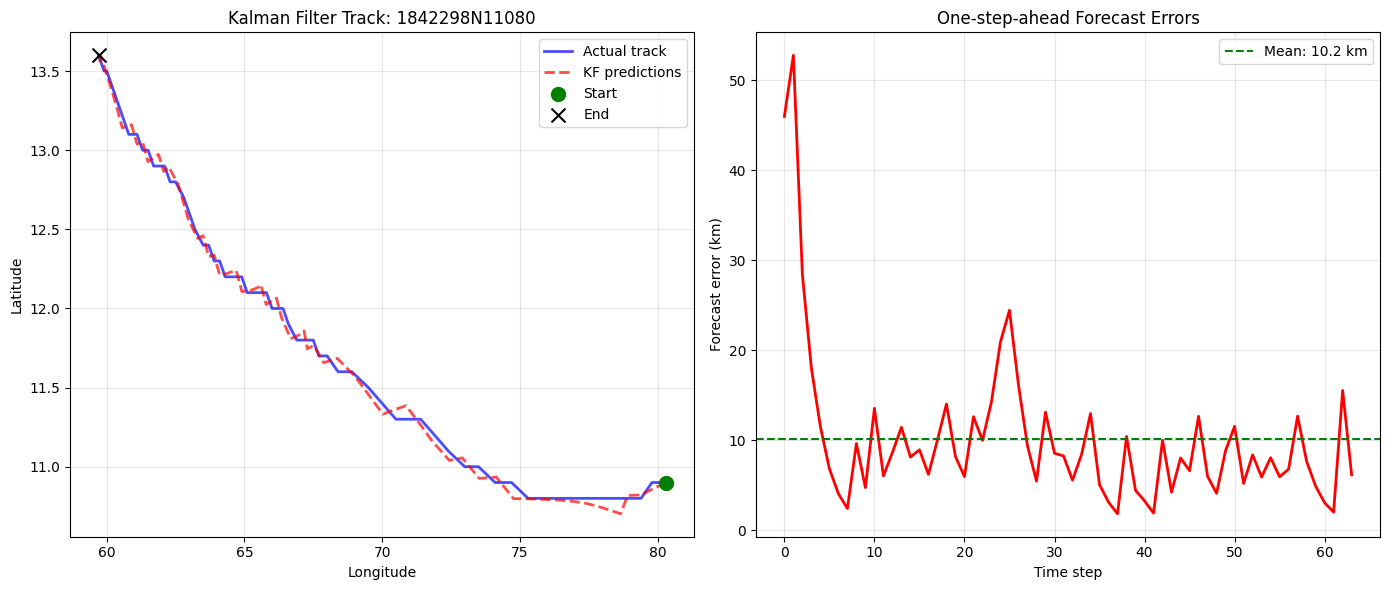

In [37]:
# Visualize filter results for test storm
# Convert metric coordinates back to lat/lon for visualization
def metric_to_latlon(x_km, y_km, lat_ref, lon_ref):
    """Convert metric coordinates back to lat/lon"""
    R_EARTH = 111.0  # km per degree
    lat = lat_ref + y_km / R_EARTH
    lon = lon_ref + x_km / (R_EARTH * np.cos(np.radians(lat_ref)))
    return lat, lon

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Track plot (convert to lat/lon for display)
ax = axes[0]
actual_track_km = results['observations']
predicted_track_km = results['predictions']

if results.get('lat_ref') and results.get('lon_ref'):
    lat_ref = results['lat_ref']
    lon_ref = results['lon_ref']
    
    # Convert to lat/lon
    actual_lat, actual_lon = metric_to_latlon(
        actual_track_km[:, 0], actual_track_km[:, 1], lat_ref, lon_ref
    )
    pred_lat, pred_lon = metric_to_latlon(
        predicted_track_km[:, 0], predicted_track_km[:, 1], lat_ref, lon_ref
    )
    
    ax.plot(actual_lon, actual_lat, 'b-', linewidth=2, label='Actual track', alpha=0.7)
    ax.plot(pred_lon, pred_lat, 'r--', linewidth=2, label='KF predictions', alpha=0.7)
    ax.scatter(actual_lon[0], actual_lat[0], color='green', s=100, marker='o', label='Start', zorder=5)
    ax.scatter(actual_lon[-1], actual_lat[-1], color='black', s=100, marker='x', label='End', zorder=5)
else:
    # Fallback: plot in metric coordinates
    ax.plot(actual_track_km[:, 0], actual_track_km[:, 1], 'b-', linewidth=2, label='Actual track', alpha=0.7)
    ax.plot(predicted_track_km[:, 0], predicted_track_km[:, 1], 'r--', linewidth=2, label='KF predictions', alpha=0.7)
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')

ax.set_xlabel('Longitude' if results.get('lat_ref') else 'x (km)')
ax.set_ylabel('Latitude' if results.get('lat_ref') else 'y (km)')
ax.set_title(f'Kalman Filter Track: {test_storm_id}')
ax.grid(True, alpha=0.3)
ax.legend()

# Error plot
if errors:
    ax = axes[1]
    ax.plot(errors['distances_km'], 'r-', linewidth=2)
    ax.axhline(y=errors['mean_error_km'], color='g', linestyle='--', label=f'Mean: {errors["mean_error_km"]:.1f} km')
    ax.set_xlabel('Time step')
    ax.set_ylabel('Forecast error (km)')
    ax.set_title('One-step-ahead Forecast Errors')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


In [38]:
# Evaluate on multiple storms
def evaluate_on_storms(df_eval, storm_ids, kf, use_features=True):
    """Evaluate Kalman filter on multiple storms"""
    all_errors = []
    
    for sid in storm_ids:
        storm = df_eval[df_eval['sid'] == sid].copy()
        if len(storm) < 3:
            continue
        
        # Create new filter instance for each storm (parameters are adapted during filtering)
        storm_kf = HurricaneKalmanFilter(q_base=kf.Q_base, r_base=kf.R_base, adaptive=kf.adaptive)
        
        results = run_kalman_filter_on_storm(storm, storm_kf, use_features=use_features)
        errors = compute_forecast_errors(results)
        
        if errors:
            all_errors.append({
                'sid': sid,
                'n_obs': len(storm),
                'mean_error': errors['mean_error_km'],
                'rmse': errors['rmse_km'],
                'median_error': errors['median_error_km']
            })
    
    return pd.DataFrame(all_errors)

# Evaluate on test set
test_eval_storms = df_test[df_test.groupby('sid')['sid'].transform('count') >= 5]['sid'].unique()

print("Evaluating on test set...")
test_results = evaluate_on_storms(df_test, test_eval_storms, kf_estimated, use_features=True)

if len(test_results) > 0:
    print(f"\nTest set evaluation ({len(test_results)} storms):")
    print(f"Mean forecast error: {test_results['mean_error'].mean():.2f} km")
    print(f"RMSE: {test_results['rmse'].mean():.2f} km")
    print(f"Median error: {test_results['median_error'].mean():.2f} km")
    print(f"\nError distribution:")
    print(test_results[['mean_error', 'rmse', 'median_error']].describe())


Evaluating on test set...

Test set evaluation (2680 storms):
Mean forecast error: 21.16 km
RMSE: 26.88 km
Median error: 16.88 km

Error distribution:
        mean_error         rmse  median_error
count  2680.000000  2680.000000   2680.000000
mean     21.162344    26.875117     16.881800
std      12.078544    16.034880     10.764610
min       4.971289     6.968561      0.000000
25%      13.817217    16.874253     11.119604
50%      18.508047    23.378618     14.606128
75%      25.163512    32.266319     19.310427
max     202.998474   221.908020    217.161838


In [39]:
# Estimate Q and R from training data
def estimate_noise_covariances(df_train, min_storm_length=5, sample_size=None):
    """Estimate process noise Q and observation noise R from training data"""
    valid_storms = df_train[df_train.groupby('sid')['sid'].transform('count') >= min_storm_length]['sid'].unique()
    
    if sample_size is not None and len(valid_storms) > sample_size:
        valid_storms = valid_storms[:sample_size]
    
    state_changes = []
    obs_residuals = []
    
    for sid in valid_storms:
        storm = df_train[df_train['sid'] == sid].sort_values('iso_time')
        storm = storm.reset_index(drop=True)
        
        if len(storm) < 2:
            continue
        
        # Check if metric coordinates exist
        if 'x_km' not in storm.columns or 'y_km' not in storm.columns:
            continue  # Skip storms without metric coordinates
        
        # Estimate Q from actual state transitions vs predicted (constant velocity model)
        for i in range(1, len(storm)):
            # Previous state in metric coordinates (km)
            state_t = np.array([
                storm['x_km'].iloc[i-1],
                storm['y_km'].iloc[i-1],
                storm['vx_km'].iloc[i-1] if not pd.isna(storm['vx_km'].iloc[i-1]) else 0.0,
                storm['vy_km'].iloc[i-1] if not pd.isna(storm['vy_km'].iloc[i-1]) else 0.0
            ])
            
            # Actual next state
            state_t1_actual = np.array([
                storm['x_km'].iloc[i],
                storm['y_km'].iloc[i],
                storm['vx_km'].iloc[i] if not pd.isna(storm['vx_km'].iloc[i]) else 0.0,
                storm['vy_km'].iloc[i] if not pd.isna(storm['vy_km'].iloc[i]) else 0.0
            ])
            
            # Predicted next state (constant velocity)
            A = np.array([
                [1, 0, 1, 0],
                [0, 1, 0, 1],
                [0, 0, 1, 0],
                [0, 0, 0, 1]
            ])
            state_t1_pred = A @ state_t
            
            # Innovation (process noise) in km units
            innovation = state_t1_actual - state_t1_pred
            state_changes.append(innovation)
        
        # Estimate R from observation residuals (position measurement error in km²)
        # Use small value for best-track data (highly accurate: ~0.5 km std)
        obs_residuals.append([0.25, 0.25])  # 0.5 km std = 0.25 km² variance
    
    if len(state_changes) > 0:
        # Estimate Q covariance
        state_changes_array = np.array(state_changes)
        Q_est = np.cov(state_changes_array.T)
        
        # Ensure Q is positive definite (add small regularization)
        Q_est = Q_est + np.eye(4) * 1e-6
        
        # Estimate R (observation noise is typically small for best-track)
        R_est = np.eye(2) * np.mean(obs_residuals)
        
        return Q_est, R_est
    
    return None, None

# Estimate parameters from training data
Q_est, R_est = estimate_noise_covariances(df_train, sample_size=200)

if Q_est is not None:
    print("Estimated noise covariances from training data:")
    print(f"Q (process noise):\n{Q_est}")
    print(f"\nR (observation noise):\n{R_est}")
    
    # Create filter with estimated parameters
    kf_estimated = HurricaneKalmanFilter(q_base=Q_est, r_base=R_est, adaptive=True)
else:
    print("Could not estimate parameters. Using default values.")
    kf_estimated = HurricaneKalmanFilter(adaptive=True)


Estimated noise covariances from training data:
Q (process noise):
[[2859.84424925  542.25405843  389.66793801  -15.87515565]
 [ 542.25405843 1678.39113123  -51.67770167  260.23061083]
 [ 389.66793801  -51.67770167  735.04799246   64.88834523]
 [ -15.87515565  260.23061083   64.88834523  442.07522514]]

R (observation noise):
[[0.25 0.  ]
 [0.   0.25]]


In [40]:
# Generate multiple forecast paths for spaghetti plots
def generate_forecast_paths(kf, n_steps, n_paths=50):
    """Generate multiple forecast paths using Monte Carlo simulation"""
    paths = []
    
    for _ in range(n_paths):
        x_sample = np.random.multivariate_normal(kf.x, kf.P)
        path = [x_sample[:2].copy()]
        
        x = x_sample.copy()
        P = kf.P.copy()
        
        for _ in range(n_steps):
            # Predict
            x = kf.A @ x
            P = kf.A @ P @ kf.A.T + kf.Q
            
            # Sample from prediction distribution
            x = np.random.multivariate_normal(x, P)
            path.append(x[:2].copy())
        
        paths.append(np.array(path))
    
    return np.array(paths)

# Example: Generate forecast paths for test storm
# Use filter with estimated parameters
forecast_kf = HurricaneKalmanFilter(q_base=kf_estimated.Q_base, r_base=kf_estimated.R_base, adaptive=kf_estimated.adaptive)
initial_state = np.array([
    test_storm['lat'].iloc[-1],
    test_storm['lon'].iloc[-1],
    test_storm['v_lat'].iloc[-1],
    test_storm['v_lon'].iloc[-1]
])
forecast_kf.initialize(initial_state)

spaghetti_paths = generate_forecast_paths(forecast_kf, n_steps=8, n_paths=50)


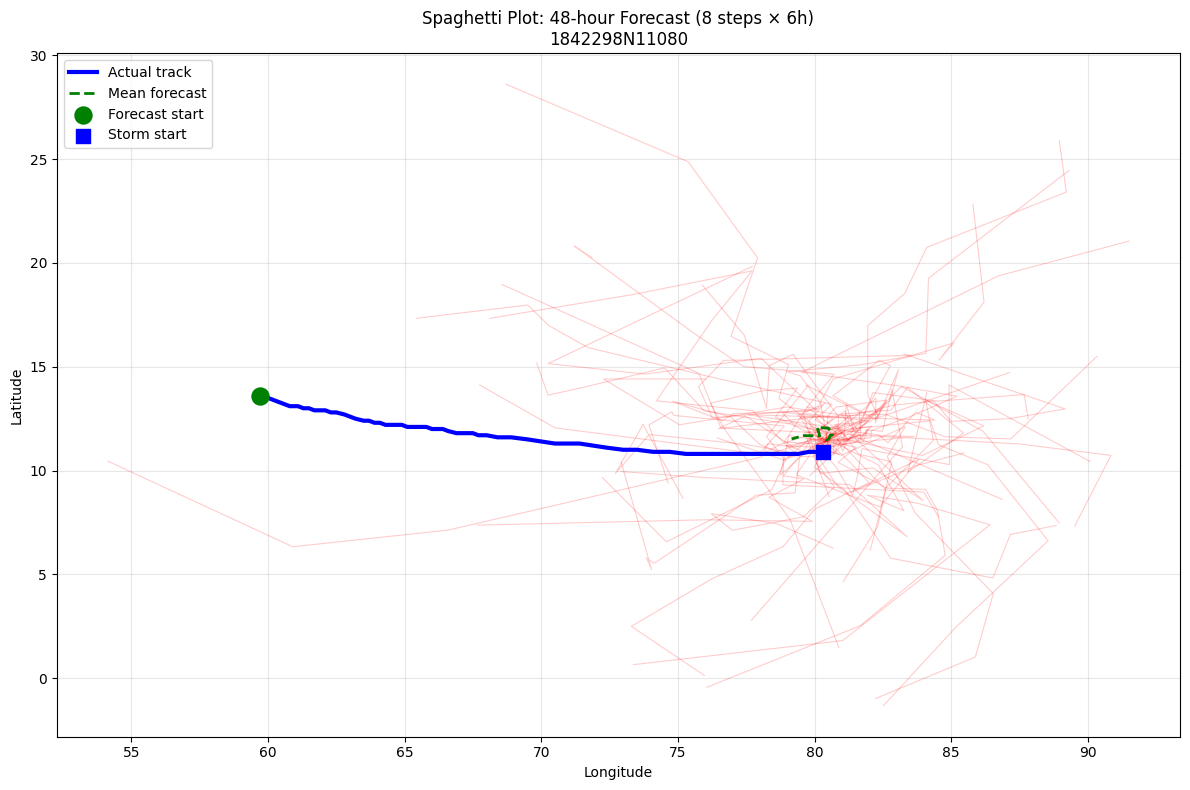

In [41]:
# Visualize spaghetti plot
if len(spaghetti_paths) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Convert metric coordinates to lat/lon for display if reference points exist
    if 'lat_ref' in test_storm.columns and 'lon_ref' in test_storm.columns:
        lat_ref = test_storm['lat_ref'].iloc[0]
        lon_ref = test_storm['lon_ref'].iloc[0]
        
        def metric_to_latlon_spaghetti(x_km, y_km):
            R_EARTH = 111.0
            lat = lat_ref + y_km / R_EARTH
            lon = lon_ref + x_km / (R_EARTH * np.cos(np.radians(lat_ref)))
            return lat, lon
        
        # Convert actual track
        actual_lat, actual_lon = metric_to_latlon_spaghetti(
            test_storm['x_km'].values, test_storm['y_km'].values
        )
        ax.plot(actual_lon, actual_lat, 
                'b-', linewidth=3, label='Actual track', zorder=10)
        
        # Convert forecast paths
        for path in spaghetti_paths:
            path_lat, path_lon = metric_to_latlon_spaghetti(path[:, 0], path[:, 1])
            ax.plot(path_lon, path_lat, 'r-', alpha=0.2, linewidth=0.8)
        
        # Convert mean forecast
        mean_path = np.mean(spaghetti_paths, axis=0)
        mean_lat, mean_lon = metric_to_latlon_spaghetti(mean_path[:, 0], mean_path[:, 1])
        ax.plot(mean_lon, mean_lat, 'g--', linewidth=2, 
                label='Mean forecast', zorder=5)
        
        # Start and end markers
        ax.scatter(actual_lon[-1], actual_lat[-1],
                  color='green', s=150, marker='o', label='Forecast start', zorder=15)
        ax.scatter(actual_lon[0], actual_lat[0],
                  color='blue', s=100, marker='s', label='Storm start', zorder=15)
        
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
    else:
        # Fallback: plot in metric coordinates
        ax.plot(test_storm['x_km'].values, test_storm['y_km'].values, 
                'b-', linewidth=3, label='Actual track', zorder=10)
        
        for path in spaghetti_paths:
            ax.plot(path[:, 0], path[:, 1], 'r-', alpha=0.2, linewidth=0.8)
        
        mean_path = np.mean(spaghetti_paths, axis=0)
        ax.plot(mean_path[:, 0], mean_path[:, 1], 'g--', linewidth=2, 
                label='Mean forecast', zorder=5)
        
        ax.scatter(test_storm['x_km'].iloc[-1], test_storm['y_km'].iloc[-1],
                  color='green', s=150, marker='o', label='Forecast start', zorder=15)
        ax.scatter(test_storm['x_km'].iloc[0], test_storm['y_km'].iloc[0],
                  color='blue', s=100, marker='s', label='Storm start', zorder=15)
        
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
    
    ax.set_title(f'Spaghetti Plot: 48-hour Forecast (8 steps × 6h)\n{test_storm_id}')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [42]:

# These functions implement true forecasting (no updates after initialization)

def initialize_filter_from_observations(storm_data, kf, t0_idx, use_features=True):
    """Initialize filter using observations up to time t0_idx, then return initialized filter
    
    This runs the filter with updates ONLY up to t0_idx, then returns the filter
    in its state at t0_idx. This is used as the starting point for open-loop forecasting.
    """
    storm_data = storm_data.sort_values('iso_time').reset_index(drop=True)
    
    if 'x_km' not in storm_data.columns or 'y_km' not in storm_data.columns:
        raise ValueError("Metric coordinates required")
    
    feature_cols = ['track_curvature', 'is_approaching_land', 'motion_regime', 
                   'latitude_regime', 'land_gradient', 'storm_stage']
    has_features = use_features and all(col in storm_data.columns for col in feature_cols)
    
    # Initialize with first observation
    initial_state = np.array([
        storm_data['x_km'].iloc[0],
        storm_data['y_km'].iloc[0],
        storm_data['vx_km'].iloc[0] if not pd.isna(storm_data['vx_km'].iloc[0]) else 0.0,
        storm_data['vy_km'].iloc[0] if not pd.isna(storm_data['vy_km'].iloc[0]) else 0.0
    ])
    kf.initialize(initial_state)
    
    # Run filter with updates up to t0_idx
    for i in range(1, min(t0_idx + 1, len(storm_data))):
        obs = np.array([storm_data['x_km'].iloc[i], storm_data['y_km'].iloc[i]])
        
        # Adapt parameters if using features
        if has_features:
            features = {col: storm_data[col].iloc[i] for col in feature_cols}
            kf.adapt_parameters(features)
        
        # Predict and update
        kf.predict()
        kf.update(obs)
    
    return kf

def open_loop_forecast(storm_data, kf, t0_idx, lead_steps, use_features=True):
    """Generate open-loop forecast: initialize from observations up to t0_idx, 
    then forecast lead_steps ahead WITHOUT any updates.
    
    Args:
        storm_data: Storm track data
        kf: KalmanFilter instance (will be modified)
        t0_idx: Index of forecast origin (uses observations up to this point)
        lead_steps: Number of steps ahead to forecast
        use_features: Whether to adapt parameters during initialization phase
    
    Returns:
        Dictionary with forecasts, true observations, and errors
    """
    storm_data = storm_data.sort_values('iso_time').reset_index(drop=True)
    
    # Create a fresh filter instance
    forecast_kf = HurricaneKalmanFilter(q_base=kf.Q_base, r_base=kf.R_base, adaptive=kf.adaptive)
    
    # Initialize filter using observations up to t0_idx
    initialize_filter_from_observations(storm_data, forecast_kf, t0_idx, use_features)
    
    # Now do open-loop forecasting (no updates)
    forecasts = []
    true_observations = []
    
    x_current = forecast_kf.x.copy()
    P_current = forecast_kf.P.copy()
    
    feature_cols = ['track_curvature', 'is_approaching_land', 'motion_regime', 
                   'latitude_regime', 'land_gradient', 'storm_stage']
    has_features = use_features and all(col in storm_data.columns for col in feature_cols)
    
    for step in range(1, lead_steps + 1):
        t_target = t0_idx + step
        
        if t_target >= len(storm_data):
            break
        
        # Adapt parameters if using features (use features from previous step if available)
        if has_features and t_target > 0:
            # Use features from t_target - 1 (last known state)
            features = {col: storm_data[col].iloc[min(t_target - 1, len(storm_data) - 1)] 
                       for col in feature_cols}
            forecast_kf.adapt_parameters(features)
        
        # Predict one step ahead (open-loop, no update)
        x_pred = forecast_kf.A @ x_current
        P_pred = forecast_kf.A @ P_current @ forecast_kf.A.T + forecast_kf.Q
        
        forecasts.append(x_pred[:2].copy())  # Store position forecast
        
        # True observation at this time (for comparison)
        true_obs = np.array([storm_data['x_km'].iloc[t_target], 
                            storm_data['y_km'].iloc[t_target]])
        true_observations.append(true_obs)
        
        # Update current state for next prediction (but don't update filter with observation)
        x_current = x_pred.copy()
        P_current = P_pred.copy()
    
    forecasts = np.array(forecasts)
    true_observations = np.array(true_observations)
    
    # Compute errors
    errors = forecasts - true_observations
    distances = np.sqrt(errors[:, 0]**2 + errors[:, 1]**2)
    
    return {
        'forecasts': forecasts,
        'true_observations': true_observations,
        'errors': errors,
        'distances_km': distances,
        'lead_times_hours': np.arange(6, (len(forecasts) + 1) * 6, 6)
    }


In [43]:
# Evaluate forecasts starting from multiple points in each storm

def evaluate_sliding_origins(df_eval, storm_ids, kf, lead_times_hours=[6, 12, 24, 48], 
                              min_origin_idx=3, max_origins_per_storm=None, use_features=True):
    """Evaluate open-loop forecasts from multiple origins (sliding window)
    
    For each storm:
    - Pick multiple forecast origins (t0_idx) along the storm track
    - For each origin, initialize filter using observations up to that point
    - Forecast ahead by lead_times_hours WITHOUT any updates
    - Collect errors across all origins and lead times
    
    Args:
        df_eval: DataFrame with storm data
        storm_ids: List of storm IDs to evaluate
        kf: KalmanFilter instance (base parameters)
        lead_times_hours: List of lead times in hours to evaluate (e.g., [6, 12, 24, 48])
        min_origin_idx: Minimum index to use as origin (need some history)
        max_origins_per_storm: Max origins to sample per storm (None = all valid)
        use_features: Whether to use feature adaptation
    
    Returns:
        DataFrame with columns: storm_id, origin_idx, lead_time_hours, error_km
    """
    all_results = []
    
    for sid in storm_ids:
        storm = df_eval[df_eval['sid'] == sid].sort_values('iso_time').reset_index(drop=True)
        
        if 'x_km' not in storm.columns or len(storm) < min_origin_idx + max(lead_times_hours) // 6 + 1:
            continue
        
        # Determine valid origins (need enough history and future)
        max_lead_steps = max(lead_times_hours) // 6
        valid_origins = range(min_origin_idx, len(storm) - max_lead_steps)
        
        if max_origins_per_storm is not None:
            # Sample origins evenly spaced
            step = max(1, len(valid_origins) // max_origins_per_storm)
            valid_origins = list(valid_origins[::step])
        
        for t0_idx in valid_origins:
            # Generate forecast from this origin
            max_steps = max_lead_steps
            forecast_result = open_loop_forecast(storm, kf, t0_idx, max_steps, use_features)
            
            # Extract errors at requested lead times
            for lead_hours in lead_times_hours:
                lead_steps = lead_hours // 6  # Convert hours to 6-hour steps
                
                if lead_steps <= len(forecast_result['distances_km']):
                    error = forecast_result['distances_km'][lead_steps - 1]
                    
                    all_results.append({
                        'storm_id': sid,
                        'origin_idx': t0_idx,
                        'lead_time_hours': lead_hours,
                        'error_km': error
                    })
    
    return pd.DataFrame(all_results)

def summarize_lead_time_errors(results_df):
    """Summarize errors by lead time"""
    summary = results_df.groupby('lead_time_hours')['error_km'].agg([
        ('mean', 'mean'),
        ('median', 'median'),
        ('rmse', lambda x: np.sqrt(np.mean(x**2))),
        ('count', 'count'),
        ('std', 'std')
    ]).round(2)
    
    return summary

# Evaluate on validation and test sets with sliding origins
print("=" * 60)
print("EVALUATING ON VALIDATION AND TEST SETS")
print("=" * 60)

# Use ALL storms from validation and test sets (not filtered by length)
# Only filter by minimum length needed for evaluation (min_origin_idx + max_lead_steps)
min_storm_length_needed = 5 + (72 // 6) + 1  # min_origin_idx + max_lead_steps + 1

print(f"\n1. VALIDATION SET EVALUATION")
print("-" * 60)
val_eval_storms = df_val[df_val.groupby('sid')['sid'].transform('count') >= min_storm_length_needed]['sid'].unique()
print(f"Evaluating on {len(val_eval_storms)} validation storms (out of {len(val_storms)} total)")
print(f"  (Filtered to storms with >= {min_storm_length_needed} observations for 72h forecast)")

val_sliding_results = evaluate_sliding_origins(
    df_val, val_eval_storms, kf_estimated,
    lead_times_hours=[6, 12, 24, 48, 72],
    min_origin_idx=5,
    max_origins_per_storm=5,  # Sample 5 origins per storm for speed        
    use_features=True
)

if len(val_sliding_results) > 0:
    print(f"\nEvaluated {len(val_sliding_results)} forecast instances on validation set")
    print("\nValidation set - Forecast accuracy by lead time (open-loop, sliding origins):")
    val_summary = summarize_lead_time_errors(val_sliding_results)
    print(val_summary)

print(f"\n2. TEST SET EVALUATION")
print("-" * 60)
test_eval_storms = df_test[df_test.groupby('sid')['sid'].transform('count') >= min_storm_length_needed]['sid'].unique()
print(f"Evaluating on {len(test_eval_storms)} test storms (out of {len(test_storms)} total)")
print(f"  (Filtered to storms with >= {min_storm_length_needed} observations for 72h forecast)")

test_sliding_results = evaluate_sliding_origins(
    df_test, test_eval_storms, kf_estimated,
    lead_times_hours=[6, 12, 24, 48, 72],
    min_origin_idx=5,
    max_origins_per_storm=5,  # Sample 5 origins per storm for speed        
    use_features=True
)

if len(test_sliding_results) > 0:
    print(f"\nEvaluated {len(test_sliding_results)} forecast instances on test set")
    print("\nTest set - Forecast accuracy by lead time (open-loop, sliding origins):")
    test_summary = summarize_lead_time_errors(test_sliding_results)
    print(test_summary)

# Store results for later use
sliding_results = test_sliding_results  # Keep for backward compatibility


EVALUATING ON VALIDATION AND TEST SETS

1. VALIDATION SET EVALUATION
------------------------------------------------------------
Evaluating on 1905 validation storms (out of 2152 total)
  (Filtered to storms with >= 18 observations for 72h forecast)

Evaluated 55360 forecast instances on validation set

Validation set - Forecast accuracy by lead time (open-loop, sliding origins):
                   mean  median    rmse  count     std
lead_time_hours                                       
6                 16.61   13.01   22.23  11072   14.76
12                34.15   26.14   46.09  11072   30.95
24                77.86   58.75  105.11  11072   70.61
48               194.08  149.06  256.79  11072  168.15
72               340.24  265.27  447.18  11072  290.20

2. TEST SET EVALUATION
------------------------------------------------------------
Evaluating on 2392 test storms (out of 2690 total)
  (Filtered to storms with >= 18 observations for 72h forecast)

Evaluated 69460 forecast insta

In [44]:

# Re-run evaluation with improved model (fitted Q/R + adaptive Q)


# Helper function for open-loop forecast with adaptive Q
def open_loop_forecast_improved(storm_data, kf, t0_idx, lead_steps, Q_base, 
                                use_adaptive_Q, adaptive_params):
    """Open-loop forecast with adaptive Q support"""
    storm_data = storm_data.sort_values('iso_time').reset_index(drop=True)
    forecast_kf = HurricaneKalmanFilter(q_base=kf.Q_base, r_base=kf.R_base, adaptive=kf.adaptive)
    initialize_filter_from_observations(storm_data, forecast_kf, t0_idx, use_features=True)
    
    forecasts = []
    true_observations = []
    x_current = forecast_kf.x.copy()
    P_current = forecast_kf.P.copy()
    
    # Use lenient check: only need at least one feature column, not all
    feature_cols = ['track_curvature', 'is_approaching_land', 'motion_regime', 
                   'latitude_regime', 'land_gradient', 'storm_stage']
    available_feature_cols = [col for col in feature_cols if col in storm_data.columns]
    has_features = use_adaptive_Q and len(available_feature_cols) > 0
    
    for step in range(1, lead_steps + 1):
        t_target = t0_idx + step
        if t_target >= len(storm_data):
            break
        
        # Compute adaptive Q_t if enabled
        Q_t = None
        if use_adaptive_Q and has_features and Q_base is not None:
            if t_target < len(storm_data):
                row = storm_data.iloc[t_target]
            else:
                row = storm_data.iloc[min(t_target - 1, len(storm_data) - 1)]
            Q_t = make_Q_t(Q_base, row, params=adaptive_params)
            
                # DEBUG prints removed to reduce notebook output size
                # Uncomment below for debugging if needed:
                #             if step <= 3:
                #                 s_t = compute_Q_scale(row, params=adaptive_params)
                #                 print(f"DEBUG [forecast step {step}]: s_t={s_t:.3f}, Q_t[0,0]={Q_t[0,0]:.2f}, Q_base[0,0]={Q_base[0,0]:.2f}")
        elif not use_adaptive_Q:
            # Use Q_base directly when adaptive Q is disabled
            Q_t = Q_base if Q_base is not None else forecast_kf.Q_base
        else:
            # Fallback to forecast_kf.Q_base if adaptive Q requested but features missing
            Q_t = forecast_kf.Q_base
        
        # Predict with adaptive Q_t (use Q_base if Q_t is None)
        x_pred = forecast_kf.A @ x_current
        Q_use = Q_t if Q_t is not None else (Q_base if Q_base is not None else forecast_kf.Q_base)
        P_pred = forecast_kf.A @ P_current @ forecast_kf.A.T + Q_use
        
        forecasts.append(x_pred[:2].copy())
        true_obs = np.array([storm_data['x_km'].iloc[t_target], 
                            storm_data['y_km'].iloc[t_target]])
        true_observations.append(true_obs)
        x_current = x_pred.copy()
        P_current = P_pred.copy()
    
    forecasts = np.array(forecasts)
    true_observations = np.array(true_observations)
    errors = forecasts - true_observations
    distances = np.sqrt(errors[:, 0]**2 + errors[:, 1]**2)
    
    return {
        'forecasts': forecasts,
        'true_observations': true_observations,
        'errors': errors,
        'distances_km': distances,
        'lead_times_hours': np.arange(6, (len(forecasts) + 1) * 6, 6)
    }

# Create KF instance with fitted Q_base and R
kf_improved = HurricaneKalmanFilter(q_base=Q_base, r_base=R, adaptive=False)

print("=" * 60)
print("IMPROVED MODEL EVALUATION")
print("=" * 60)
print(f"Using fitted Q_base and R")
print(f"Adaptive Q: {use_adaptive_Q}")
if use_adaptive_Q:
    print(f"Adaptive params: {adaptive_params}")

# Re-run evaluation with improved model on validation and test sets
print("=" * 60)
print("IMPROVED MODEL EVALUATION ON VALIDATION AND TEST SETS")
print("=" * 60)

min_storm_length_needed = 5 + (72 // 6) + 1

# Evaluate on validation set
print(f"\n1. VALIDATION SET EVALUATION")
print("-" * 60)
val_eval_storms_improved = df_val[df_val.groupby('sid')['sid'].transform('count') >= min_storm_length_needed]['sid'].unique()
print(f"Evaluating on {len(val_eval_storms_improved)} validation storms")

val_results_improved = []

for sid in val_eval_storms_improved:
    storm = df_val[df_val['sid'] == sid].sort_values('iso_time').reset_index(drop=True)
    
    if 'x_km' not in storm.columns or len(storm) < 5 + 72 // 6 + 1:
        continue
    
    max_lead_steps = 72 // 6
    valid_origins = range(5, len(storm) - max_lead_steps)
    step = max(1, len(valid_origins) // 5)
    valid_origins = list(valid_origins[::step])
    
    for t0_idx in valid_origins:
        max_steps = max_lead_steps
        forecast_result = open_loop_forecast_improved(storm, kf_improved, t0_idx, max_steps,
                                                      Q_base, use_adaptive_Q, adaptive_params)
        
        # Extract errors at requested lead times
        for lead_hours in [6, 12, 24, 48, 72]:
            lead_steps = lead_hours // 6
            if lead_steps <= len(forecast_result['distances_km']):
                error = forecast_result['distances_km'][lead_steps - 1]
                val_results_improved.append({
                    'storm_id': sid,
                    'origin_idx': t0_idx,
                    'lead_time_hours': lead_hours,
                    'error_km': error
                })

val_sliding_results_improved = pd.DataFrame(val_results_improved)

# Evaluate on test set
print(f"\n2. TEST SET EVALUATION")
print("-" * 60)
test_eval_storms_improved = df_test[df_test.groupby('sid')['sid'].transform('count') >= min_storm_length_needed]['sid'].unique()
print(f"Evaluating on {len(test_eval_storms_improved)} test storms")

test_results_improved = []

for sid in test_eval_storms_improved:
    storm = df_test[df_test['sid'] == sid].sort_values('iso_time').reset_index(drop=True)
    
    if 'x_km' not in storm.columns or len(storm) < 5 + 72 // 6 + 1:
        continue
    
    max_lead_steps = 72 // 6
    valid_origins = range(5, len(storm) - max_lead_steps)
    step = max(1, len(valid_origins) // 5)
    valid_origins = list(valid_origins[::step])
    
    for t0_idx in valid_origins:
        max_steps = max_lead_steps
        forecast_result = open_loop_forecast_improved(storm, kf_improved, t0_idx, max_steps,
                                                      Q_base, use_adaptive_Q, adaptive_params)
        
        # Extract errors at requested lead times
        for lead_hours in [6, 12, 24, 48, 72]:
            lead_steps = lead_hours // 6
            if lead_steps <= len(forecast_result['distances_km']):
                error = forecast_result['distances_km'][lead_steps - 1]
                test_results_improved.append({
                    'storm_id': sid,
                    'origin_idx': t0_idx,
                    'lead_time_hours': lead_hours,
                    'error_km': error
                })

test_sliding_results_improved = pd.DataFrame(test_results_improved)

# Print results
if len(val_sliding_results_improved) > 0:
    print(f"\nValidation set - Evaluated {len(val_sliding_results_improved)} forecast instances")
    print("\nValidation set - Improved model - Forecast accuracy by lead time:")
    val_summary_improved = summarize_lead_time_errors(val_sliding_results_improved)
    print(val_summary_improved)

if len(test_sliding_results_improved) > 0:
    print(f"\nTest set - Evaluated {len(test_sliding_results_improved)} forecast instances")
    print("\nTest set - Improved model - Forecast accuracy by lead time:")
    test_summary_improved = summarize_lead_time_errors(test_sliding_results_improved)
    print(test_summary_improved)
    
    # Compare with baseline
    print("\n" + "=" * 60)
    print("COMPARISON WITH BASELINE MODEL")
    print("=" * 60)
    print("\nBaseline model (from Cell 21):")
    if 'test_summary' in globals():
        for lead_time in [6, 12, 24, 48, 72]:
            if lead_time in test_summary.index:
                rmse = test_summary.loc[lead_time, 'rmse']
                print(f"  Lead time {lead_time}h: RMSE {rmse:.2f} km")
    else:
        print("  (Baseline results not available)")
    
    print("\nImproved model (fitted Q/R + adaptive Q):")
    for lead_time in [6, 12, 24, 48, 72]:
        if lead_time in test_summary_improved.index:
            rmse = test_summary_improved.loc[lead_time, 'rmse']
            print(f"  Lead time {lead_time}h: RMSE {rmse:.2f} km")

# Store for backward compatibility
sliding_results_improved = test_sliding_results_improved


IMPROVED MODEL EVALUATION
Using fitted Q_base and R
Adaptive Q: True
Adaptive params: {'alpha_curvature': 0.5, 'alpha_land': 0.5, 'alpha_recurving': 0.5, 'alpha_westward': 0.1, 'alpha_midlat': 0.2, 's_min': 0.5, 's_max': 3.0}
IMPROVED MODEL EVALUATION ON VALIDATION AND TEST SETS

1. VALIDATION SET EVALUATION
------------------------------------------------------------
Evaluating on 1905 validation storms

2. TEST SET EVALUATION
------------------------------------------------------------
Evaluating on 2392 test storms

Validation set - Evaluated 55360 forecast instances

Validation set - Improved model - Forecast accuracy by lead time:
                   mean  median    rmse  count     std
lead_time_hours                                       
6                 16.21   12.85   21.61  11072   14.29
12                33.37   25.60   44.87  11072   30.00
24                76.46   57.95  102.98  11072   68.98
48               191.75  147.99  253.37  11072  165.62
72               337.04  2

In [45]:

# Hyperparameter Tuning for Adaptive Q Parameters


def evaluate_open_loop_for_tuning(df_eval, storm_ids, Q_base, R, adaptive_params,
                                   lead_times_hours=[24, 48], 
                                   min_origin_idx=5, max_origins_per_storm=3,
                                   max_storms=None, use_adaptive_Q=True):
    """
    Evaluate open-loop forecasts for hyperparameter tuning.
    Returns RMSE by lead time.
    
    Args:
        df_eval: DataFrame with storm data
        storm_ids: List of storm IDs to evaluate
        Q_base: Base process noise covariance
        R: Observation noise covariance
        adaptive_params: Adaptive Q parameters
        lead_times_hours: Lead times to evaluate
        min_origin_idx: Minimum origin index
        max_origins_per_storm: Max origins per storm (for speed)
        max_storms: Limit number of storms (for speed)
    
    Returns:
        DataFrame with RMSE by lead time
    """
    if max_storms is not None and len(storm_ids) > max_storms:
        np.random.seed(42)
        storm_ids = np.random.choice(storm_ids, size=max_storms, replace=False)
    
    # Create KF instance
    kf = HurricaneKalmanFilter(q_base=Q_base, r_base=R, adaptive=False)
    
    all_results = []
    
    for sid in storm_ids:
        storm = df_eval[df_eval['sid'] == sid].sort_values('iso_time').reset_index(drop=True)
        
        if 'x_km' not in storm.columns or len(storm) < min_origin_idx + max(lead_times_hours) // 6 + 1:
            continue
        
        max_lead_steps = max(lead_times_hours) // 6
        valid_origins = range(min_origin_idx, len(storm) - max_lead_steps)
        
        if max_origins_per_storm is not None:
            step = max(1, len(valid_origins) // max_origins_per_storm)
            valid_origins = list(valid_origins[::step])
        
        for t0_idx in valid_origins:
            max_steps = max_lead_steps
            forecast_result = open_loop_forecast_improved(
                storm, kf, t0_idx, max_steps,
                Q_base, use_adaptive_Q=use_adaptive_Q, adaptive_params=adaptive_params
            )
            
            # Extract errors at requested lead times
            for lead_hours in lead_times_hours:
                lead_steps = lead_hours // 6
                if lead_steps <= len(forecast_result['distances_km']):
                    error = forecast_result['distances_km'][lead_steps - 1]
                    all_results.append({
                        'storm_id': sid,
                        'origin_idx': t0_idx,
                        'lead_time_hours': lead_hours,
                        'error_km': error
                    })
    
    if len(all_results) == 0:
        return None
    
    results_df = pd.DataFrame(all_results)
    summary = results_df.groupby('lead_time_hours')['error_km'].agg([
        ('rmse', lambda x: np.sqrt(np.mean(x**2))),
        ('count', 'count')
    ])
    
    return summary


def tune_adaptive_Q(df_modeling, inner_train_storms, val_storms, n_trials=30,
                    weight_24h=0.5, weight_48h=0.5,
                    max_val_storms=200, max_origins_per_storm=3):
    """
    Tune adaptive Q parameters using random search.
    
    Args:
        df_modeling: Full modeling dataframe
        inner_train_storms: Storm IDs for fitting Q/R
        val_storms: Storm IDs for validation
        n_trials: Number of random trials
        weight_24h: Weight for 24h RMSE in objective
        weight_48h: Weight for 48h RMSE in objective
        max_val_storms: Max storms to use for validation (for speed)
        max_origins_per_storm: Max origins per storm (for speed)
    
    Returns:
        best_params: Best adaptive parameters found
        best_score: Best score achieved
        trial_results: List of all trial results
    """
    df_inner_train = df_modeling[df_modeling['sid'].isin(inner_train_storms)].copy()
    
    best_score = np.inf
    best_params = None
    trial_results = []
    
    print(f"Starting hyperparameter tuning with {n_trials} trials...")
    print(f"Using {len(inner_train_storms)} storms for Q/R fitting")
    print(f"Using up to {max_val_storms} validation storms for evaluation")

    for trial in range(n_trials):
        # Sample adaptive parameters (milder ranges)
        adaptive_params = {
            'alpha_curvature': np.random.uniform(0.0, 1.0),
            'alpha_land': np.random.uniform(0.0, 1.5),
            'alpha_recurving': np.random.uniform(0.0, 1.5),
            'alpha_westward': np.random.uniform(0.0, 0.5),
            'alpha_midlat': np.random.uniform(0.0, 0.7),
            's_min': 0.5,
            's_max': 3.0,  # Lowered from 5.0 to prevent extreme scaling
        }
        
        try:
            # Fit Q/R on inner_train
            Q_base, R = fit_QR(df_inner_train, min_storm_length=10, sample_size=None)
            
            # VERIFICATION: Check that adaptive params actually change Q scaling
            if trial == 0 or trial == 1:
                # Sample a random row to verify scaling
                sample_storm = df_modeling[df_modeling['sid'].isin(val_storms[:1])].iloc[0] if len(val_storms) > 0 else None
                if sample_storm is not None:
                    s_t = compute_Q_scale(sample_storm, params=adaptive_params)
                    print(f"Trial {trial+1}: Sample s_t = {s_t:.3f} (params: alpha_curv={adaptive_params['alpha_curvature']:.2f}, alpha_land={adaptive_params['alpha_land']:.2f})")
                    if s_t == 1.0:
                        print(f"  WARNING: s_t is 1.0 - adaptive params may not be having effect!")
            
            # Evaluate on validation set with adaptive Q ENABLED
            metrics = evaluate_open_loop_for_tuning(
                df_modeling, val_storms, Q_base, R, adaptive_params,
                lead_times_hours=[24, 48],
                min_origin_idx=5,
                max_origins_per_storm=max_origins_per_storm,
                max_storms=max_val_storms,
                use_adaptive_Q=True  # Explicitly enable adaptive Q
            )
            
            if metrics is None or len(metrics) == 0:
                print(f"Trial {trial+1}/{n_trials}: No valid results, skipping")
                continue
            
            # Get RMSE at 24h and 48h
            rmse_24 = metrics.loc[24, 'rmse'] if 24 in metrics.index else np.inf
            rmse_48 = metrics.loc[48, 'rmse'] if 48 in metrics.index else np.inf
            
            # Compute scalar score
            score = weight_24h * rmse_24 + weight_48h * rmse_48
            
            trial_results.append({
                'trial': trial + 1,
                'params': adaptive_params.copy(),
                'rmse_24h': rmse_24,
                'rmse_48h': rmse_48,
                'score': score
            })
            
            # Keep best
            if score < best_score:
                best_score = score
                best_params = adaptive_params.copy()
                print(f"  Score: {score:.2f} (24h RMSE: {rmse_24:.2f} km, 48h RMSE: {rmse_48:.2f} km)")
                print(f"  Params: {best_params}")
            else:
                if (trial + 1) % 5 == 0:
                    print(f"Trial {trial+1}/{n_trials}: Score {score:.2f} (best: {best_score:.2f})")
        
        except Exception as e:
            print(f"Trial {trial+1}/{n_trials}: Error - {e}")
            continue
    
    print(f"Best score: {best_score:.2f}")
    print(f"Best parameters: {best_params}")
    
    return best_params, best_score, trial_results


In [46]:


if 'best_params_tuned' in globals() and 'best_score_tuned' in globals():
    tuning_results_file = 'data/kalman_tuning_results.pkl'
    tuning_data = {
        'best_params_tuned': best_params_tuned,
        'best_score_tuned': best_score_tuned,
        'trial_results': trial_results if 'trial_results' in globals() else [],
        'tuning_date': pd.Timestamp.now().isoformat()
    }
    os.makedirs('data', exist_ok=True)
    with open(tuning_results_file, 'wb') as f:
        pickle.dump(tuning_data, f)
    print(f"✓ Saved existing tuning results to {tuning_results_file}")
    print(f"  Best score: {best_score_tuned:.2f}")
    print(f"  Best parameters: {best_params_tuned}")
else:
    print("No tuning results found in memory. Run Cell 24 to perform tuning or load saved results.")


No tuning results found in memory. Run Cell 24 to perform tuning or load saved results.


In [47]:

# Hyperparameter Tuning - Load saved results if available, otherwise run tuning

# Check if tuning results already exist
tuning_results_file = 'data/kalman_tuning_results.pkl'
skip_tuning = False

if os.path.exists(tuning_results_file):
    print("=" * 60)
    print("LOADING SAVED TUNING RESULTS")
    print("=" * 60)
    try:
        with open(tuning_results_file, 'rb') as f:
            tuning_data = pickle.load(f)
        
        best_params_tuned = tuning_data['best_params_tuned']
        best_score_tuned = tuning_data['best_score_tuned']
        trial_results = tuning_data.get('trial_results', [])
        
        print(f"✓ Loaded saved tuning results from {tuning_results_file}")
        print(f"  Best score: {best_score_tuned:.2f}")
        print(f"  Best parameters: {best_params_tuned}")
        print(f"  Number of trials: {len(trial_results)}")
        print("\n" + "=" * 60)
        print("SKIPPING TUNING (using saved results)")
        print("=" * 60)
        print("To rerun tuning, delete the file: data/kalman_tuning_results.pkl")
        skip_tuning = True
    except Exception as e:
        print(f"Error loading tuning results: {e}")
        print("Will run tuning instead...")
        skip_tuning = False

if not skip_tuning:
    # Optional: Check curvature distribution and normalize if needed
    if 'track_curvature' in df_modeling.columns:
        curvature_values = df_modeling['track_curvature'].dropna()
        if len(curvature_values) > 0:
            print("Track curvature statistics:")
            print(f"  Mean: {curvature_values.mean():.4f}")
            print(f"  Median: {curvature_values.median():.4f}")
            print(f"  90th percentile: {curvature_values.quantile(0.90):.4f}")
            print(f"  95th percentile: {curvature_values.quantile(0.95):.4f}")
            print(f"  Max: {curvature_values.max():.4f}")
            print()

    # Run tuning (start with fewer trials for testing, increase for final tuning)
    print("=" * 60)
    print("STARTING HYPERPARAMETER TUNING")
    print("=" * 60)
    print("WARNING: This may take several hours!")
    print("Results will be saved automatically when complete.")
    print("=" * 60)
    
    best_params_tuned, best_score_tuned, trial_results = tune_adaptive_Q(
        df_modeling,
        inner_train_storms,
        val_storms,
        n_trials=30,  # Increase to 50-100 for more thorough search
        weight_24h=0.5,
        weight_48h=0.5,
        max_val_storms=200,  # Use subset for speed
        max_origins_per_storm=3  # Limit origins per storm for speed
    )
    
    # Save tuning results
    print("\n" + "=" * 60)
    print("SAVING TUNING RESULTS")
    print("=" * 60)
    tuning_data = {
        'best_params_tuned': best_params_tuned,
        'best_score_tuned': best_score_tuned,
        'trial_results': trial_results,
        'tuning_date': pd.Timestamp.now().isoformat()
    }
    os.makedirs('data', exist_ok=True)
    with open(tuning_results_file, 'wb') as f:
        pickle.dump(tuning_data, f)
    print(f"✓ Saved tuning results to {tuning_results_file}")
    print("=" * 60)

# Display top 5 trials
if trial_results:
    trial_df = pd.DataFrame(trial_results)
    trial_df = trial_df.sort_values('score').head(5)
    print("\n" + "=" * 60)
    print("TOP 5 TRIALS:")
    print("=" * 60)

    for idx, row in trial_df.iterrows():
        print(f"\nTrial {row['trial']}: Score = {row['score']:.2f}")
        print(f"  24h RMSE: {row['rmse_24h']:.2f} km, 48h RMSE: {row['rmse_48h']:.2f} km")
        print(f"  Params: {row['params']}")


Track curvature statistics:
  Mean: 1.8784
  Median: 0.4167
  90th percentile: 2.5000
  95th percentile: 5.0000
  Max: 179.9998

STARTING HYPERPARAMETER TUNING
Results will be saved automatically when complete.
Starting hyperparameter tuning with 30 trials...
Using 8607 storms for Q/R fitting
Using up to 200 validation storms for evaluation
Trial 1: Sample s_t = 1.587 (params: alpha_curv=0.52, alpha_land=1.29)
  Score: 197.34 (24h RMSE: 112.19 km, 48h RMSE: 282.49 km)
  Params: {'alpha_curvature': 0.5192800823952713, 'alpha_land': 1.2869279181035045, 'alpha_recurving': 0.5870671400456204, 'alpha_westward': 0.4443466073923992, 'alpha_midlat': 0.1681590164768817, 's_min': 0.5, 's_max': 3.0}
Trial 2: Sample s_t = 1.851 (params: alpha_curv=0.71, alpha_land=0.16)
Trial 5/30: Score 197.34 (best: 197.34)
Trial 10/30: Score 197.34 (best: 197.34)
Trial 15/30: Score 197.34 (best: 197.34)
Trial 20/30: Score 197.34 (best: 197.34)
Trial 25/30: Score 197.34 (best: 197.34)
Trial 30/30: Score 197.34 (

In [48]:

# Final Evaluation with Tuned Parameters


# Refit Q/R on FULL training set (not just inner_train)
print("Refitting Q/R on full training set...")
Q_base_final, R_final = fit_QR(df_train, min_storm_length=10, sample_size=None)

# CRITICAL: Use best_params_tuned from tuning, NOT the old adaptive_params
# Verify that best_params_tuned exists
if 'best_params_tuned' not in globals():
    raise NameError("best_params_tuned not found ")

print(f"\nUsing tuned adaptive parameters (from hyperparameter tuning):")
print(best_params_tuned)

# Overwrite the global adaptive_params to ensure it's used everywhere
adaptive_params = best_params_tuned.copy()
print(f"\n Updated global adaptive_params to use tuned values")

# Create final KF instance
kf_final = HurricaneKalmanFilter(q_base=Q_base_final, r_base=R_final, adaptive=False)

# Evaluate on validation and test sets with tuned parameters
print("=" * 60)
print("FINAL EVALUATION WITH TUNED PARAMETERS")
print("=" * 60)
print("Evaluating on validation and test sets with tuned adaptive Q parameters...")

min_storm_length_needed = 5 + (72 // 6) + 1

# Evaluate on validation set
print(f"\n1. VALIDATION SET EVALUATION")
print("-" * 60)
val_eval_storms_final = df_val[df_val.groupby('sid')['sid'].transform('count') >= min_storm_length_needed]['sid'].unique()
print(f"Evaluating on {len(val_eval_storms_final)} validation storms")

val_results_final = []

for sid in val_eval_storms_final:
    storm = df_val[df_val['sid'] == sid].sort_values('iso_time').reset_index(drop=True)
    
    if 'x_km' not in storm.columns or len(storm) < 5 + 72 // 6 + 1:
        continue
    
    max_lead_steps = 72 // 6
    valid_origins = range(5, len(storm) - max_lead_steps)
    step = max(1, len(valid_origins) // 5)
    valid_origins = list(valid_origins[::step])
    
    for t0_idx in valid_origins:
        max_steps = max_lead_steps
        # CRITICAL: Explicitly use best_params_tuned, not the old adaptive_params
        forecast_result = open_loop_forecast_improved(
            storm, kf_final, t0_idx, max_steps,
            Q_base_final, 
            use_adaptive_Q=True,  # Explicitly enable adaptive Q
            adaptive_params=best_params_tuned  # Use TUNED parameters, not defaults
        )
        
        # Extract errors at requested lead times
        for lead_hours in [6, 12, 24, 48, 72]:
            lead_steps = lead_hours // 6
            if lead_steps <= len(forecast_result['distances_km']):
                error = forecast_result['distances_km'][lead_steps - 1]
                val_results_final.append({
                    'storm_id': sid,
                    'origin_idx': t0_idx,
                    'lead_time_hours': lead_hours,
                    'error_km': error
                })

val_sliding_results_final = pd.DataFrame(val_results_final)

# Evaluate on test set
print(f"\n2. TEST SET EVALUATION")
print("-" * 60)
test_eval_storms_final = df_test[df_test.groupby('sid')['sid'].transform('count') >= min_storm_length_needed]['sid'].unique()
print(f"Evaluating on {len(test_eval_storms_final)} test storms")

test_results_final = []

for sid in test_eval_storms_final:
    storm = df_test[df_test['sid'] == sid].sort_values('iso_time').reset_index(drop=True)
    
    if 'x_km' not in storm.columns or len(storm) < 5 + 72 // 6 + 1:
        continue
    
    max_lead_steps = 72 // 6
    valid_origins = range(5, len(storm) - max_lead_steps)
    step = max(1, len(valid_origins) // 5)
    valid_origins = list(valid_origins[::step])
    
    for t0_idx in valid_origins:
        max_steps = max_lead_steps
        # CRITICAL: Explicitly use best_params_tuned, not the old adaptive_params
        forecast_result = open_loop_forecast_improved(
            storm, kf_final, t0_idx, max_steps,
            Q_base_final, 
            use_adaptive_Q=True,  # Explicitly enable adaptive Q
            adaptive_params=best_params_tuned  # Use TUNED parameters, not defaults
        )
        
        # Extract errors at requested lead times
        for lead_hours in [6, 12, 24, 48, 72]:
            lead_steps = lead_hours // 6
            if lead_steps <= len(forecast_result['distances_km']):
                error = forecast_result['distances_km'][lead_steps - 1]
                test_results_final.append({
                    'storm_id': sid,
                    'origin_idx': t0_idx,
                    'lead_time_hours': lead_hours,
                    'error_km': error
                })

test_sliding_results_final = pd.DataFrame(test_results_final)

# Print results
if len(val_sliding_results_final) > 0:
    print(f"\nValidation set - Evaluated {len(val_sliding_results_final)} forecast instances")
    print("\nValidation set - Final model (tuned adaptive Q) - Forecast accuracy by lead time:")
    val_summary_final = summarize_lead_time_errors(val_sliding_results_final)
    print(val_summary_final)

if len(test_sliding_results_final) > 0:
    print(f"\nTest set - Evaluated {len(test_sliding_results_final)} forecast instances")
    print("\nTest set - Final model (tuned adaptive Q) - Forecast accuracy by lead time:")
    test_summary_final = summarize_lead_time_errors(test_sliding_results_final)
    print(test_summary_final)
    
    # Compare with baseline
    print("\n" + "=" * 60)
    print("COMPARISON WITH BASELINE MODEL")
    print("=" * 60)
    print("\nBaseline model (from Cell 21):")
    if 'test_summary' in globals():
        for lead_time in [6, 12, 24, 48, 72]:
            if lead_time in test_summary.index:
                rmse = test_summary.loc[lead_time, 'rmse']
                print(f"  Lead time {lead_time}h: RMSE {rmse:.2f} km")
    else:
        print("  (Baseline results not available)")
    
    print("\nTuned model (fitted Q/R + tuned adaptive Q):")
    for lead_time in [6, 12, 24, 48, 72]:
        if lead_time in test_summary_final.index:
            rmse = test_summary_final.loc[lead_time, 'rmse']
            print(f"  Lead time {lead_time}h: RMSE {rmse:.2f} km")
    
    # Compute improvement
    print("\nImprovement:")
    if 'test_summary' in globals() and 24 in test_summary.index and 48 in test_summary.index:
        baseline_24h = test_summary.loc[24, 'rmse']
        baseline_48h = test_summary.loc[48, 'rmse']
        if 24 in test_summary_final.index and 48 in test_summary_final.index:
            final_24h = test_summary_final.loc[24, 'rmse']
            final_48h = test_summary_final.loc[48, 'rmse']
            improvement_24h = ((baseline_24h - final_24h) / baseline_24h) * 100
            improvement_48h = ((baseline_48h - final_48h) / baseline_48h) * 100
            print(f"  24h: {improvement_24h:+.1f}% improvement ({baseline_24h:.2f} -> {final_24h:.2f} km)")
            print(f"  48h: {improvement_48h:+.1f}% improvement ({baseline_48h:.2f} -> {final_48h:.2f} km)")

# Store for backward compatibility
sliding_results_final = test_sliding_results_final


Refitting Q/R on full training set...

Using tuned adaptive parameters (from hyperparameter tuning):
{'alpha_curvature': 0.5192800823952713, 'alpha_land': 1.2869279181035045, 'alpha_recurving': 0.5870671400456204, 'alpha_westward': 0.4443466073923992, 'alpha_midlat': 0.1681590164768817, 's_min': 0.5, 's_max': 3.0}

 Updated global adaptive_params to use tuned values
FINAL EVALUATION WITH TUNED PARAMETERS
Evaluating on validation and test sets with tuned adaptive Q parameters...

1. VALIDATION SET EVALUATION
------------------------------------------------------------
Evaluating on 1905 validation storms

2. TEST SET EVALUATION
------------------------------------------------------------
Evaluating on 2392 test storms

Validation set - Evaluated 55360 forecast instances

Validation set - Final model (tuned adaptive Q) - Forecast accuracy by lead time:
                   mean  median    rmse  count     std
lead_time_hours                                       
6                 16.21   1

In [49]:

# VERIFICATION: Test Baseline vs Improved 

# Use a single test storm for verification
test_storm_id = df_test[df_test.groupby('sid')['sid'].transform('count') >= 20]['sid'].iloc[0]
test_storm = df_test[df_test['sid'] == test_storm_id].copy()
print(f"Testing on storm: {test_storm_id}")

# Fit Q/R once
Q_base_test, R_test = fit_QR(df_inner_train, min_storm_length=10, sample_size=None)

# Test parameters (non-zero to see difference)
test_adaptive_params = {
    'alpha_curvature': 0.5,
    'alpha_land': 0.5,
    'alpha_recurving': 0.3,
    'alpha_westward': 0.1,
    'alpha_midlat': 0.2,
    's_min': 0.5,
    's_max': 3.0,  # Lowered from 5.0
}

kf_test = HurricaneKalmanFilter(q_base=Q_base_test, r_base=R_test, adaptive=False)

print("\n" + "-" * 60)
print("BASELINE (use_adaptive_Q=False):")
print("-" * 60)
result_baseline = open_loop_forecast_improved(
    test_storm, kf_test, t0_idx=10, lead_steps=8,
    Q_base=Q_base_test, use_adaptive_Q=False, adaptive_params=None
)
print(f"Baseline forecast errors (first 3 steps): {result_baseline['distances_km'][:3]}")

print("\n" + "-" * 60)
print("IMPROVED (use_adaptive_Q=True):")
print("-" * 60)
result_improved = open_loop_forecast_improved(
    test_storm, kf_test, t0_idx=10, lead_steps=8,
    Q_base=Q_base_test, use_adaptive_Q=True, adaptive_params=test_adaptive_params
)
print(f"Improved forecast errors (first 3 steps): {result_improved['distances_km'][:3]}")

print("\n" + "-" * 60)
print("COMPARISON:")
print("-" * 60)
print(f"Baseline 24h RMSE: {np.sqrt(np.mean(result_baseline['distances_km'][3]**2)):.2f} km")
print(f"Improved 24h RMSE: {np.sqrt(np.mean(result_improved['distances_km'][3]**2)):.2f} km")
print(f"\nErrors are {'DIFFERENT' if not np.allclose(result_baseline['distances_km'], result_improved['distances_km'], rtol=1e-3) else 'IDENTICAL'}")



Testing on storm: 1842298N11080

------------------------------------------------------------
BASELINE (use_adaptive_Q=False):
------------------------------------------------------------
Baseline forecast errors (first 3 steps): [13.65101991 19.30823174 32.50705246]

------------------------------------------------------------
IMPROVED (use_adaptive_Q=True):
------------------------------------------------------------
Improved forecast errors (first 3 steps): [13.65101991 19.30823174 32.50705246]

------------------------------------------------------------
COMPARISON:
------------------------------------------------------------
Baseline 24h RMSE: 30.42 km
Improved 24h RMSE: 30.42 km

Errors are IDENTICAL


In [51]:
result_vars = [
    'sliding_results',
    'sliding_results_improved',
    'sliding_results_final',
    'val_sliding_results',  # Validation set results (initial evaluation)
    'val_sliding_results_improved',  # Validation set results (improved model)
    'val_sliding_results_final',  # Validation set results (final tuned model)
    'innovation_df',
    'test_results',
    'trial_results',
]

save_dir = "data"
os.makedirs(save_dir, exist_ok=True)

# Try saving any existing DataFrames
saved_any = False
for name in result_vars:
    if name in globals() and isinstance(globals()[name], pd.DataFrame):
        # Standardize column name: rename 'storm_id' to 'sid' for consistency
        df_to_save = globals()[name].copy()
        if 'storm_id' in df_to_save.columns and 'sid' not in df_to_save.columns:
            df_to_save = df_to_save.rename(columns={'storm_id': 'sid'})
        df_to_save.to_pickle(f"{save_dir}/{name}.pkl")
        print(f"Saved {name} ({len(df_to_save)} rows) to {save_dir}/{name}.pkl")
        saved_any = True

# Check if any files exist afterward
existing_files = [
    f"{save_dir}/{name}.pkl"
    for name in result_vars
    if os.path.exists(f"{save_dir}/{name}.pkl")
]

# Final summary
if saved_any:
    saved_count = len([f for f in existing_files if os.path.exists(f)])
    saved_names = [name for name in result_vars if os.path.exists(f'{save_dir}/{name}.pkl')]
    print(f"\n✓ Successfully saved {saved_count} result files to {save_dir}/")
    print(f"  Files saved: {saved_names}")
elif existing_files:
    print(f"Files already exist: {existing_files}")
else:
    print("No files saved - check that result variables exist in memory.")




Saved sliding_results (69460 rows) to data/sliding_results.pkl
Saved sliding_results_improved (69460 rows) to data/sliding_results_improved.pkl
Saved sliding_results_final (69460 rows) to data/sliding_results_final.pkl
Saved val_sliding_results (55360 rows) to data/val_sliding_results.pkl
Saved val_sliding_results_improved (55360 rows) to data/val_sliding_results_improved.pkl
Saved val_sliding_results_final (55360 rows) to data/val_sliding_results_final.pkl
Saved innovation_df (26049 rows) to data/innovation_df.pkl
Saved test_results (2680 rows) to data/test_results.pkl

✓ Successfully saved 8 result files to data/
  Files saved: ['sliding_results', 'sliding_results_improved', 'sliding_results_final', 'val_sliding_results', 'val_sliding_results_improved', 'val_sliding_results_final', 'innovation_df', 'test_results']
